
# Required Imports


In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd
import glob
import nltk

import itertools
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import chart_studio.plotly as py
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering

import gensim.models.word2vec as w2v
from sklearn.manifold import TSNE
import plotly.express as px

from collections import defaultdict
from scipy.cluster.hierarchy import dendrogram, set_link_color_palette
from fastcluster import linkage
from matplotlib.colors import rgb2hex, colorConverter

/Users/rishabhsrivastava/mypython/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/rishabhsrivastava/mypython/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/rishabhsrivastava/mypython/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/rishabhsrivastava/mypython/lib/python3.8/s


# Reading all csv's and creating a dataframe(for english language)


In [2]:
all_files=glob.glob("/Users/rishabhsrivastava/Downloads/CSVS/DIKSHA APP REVIEWS AND RATINGS/"+"/*.csv")
dflist = []


In [3]:
for filename in all_files:
    # Dataframe of one file
    df_sm = pd.read_csv(filename, index_col=None, header=0)
    dflist.append(df_sm)
    
df = pd.concat(dflist, axis=0, ignore_index=True)


In [4]:
df.dropna(subset=["Review Text"],inplace=True)


In [5]:
eng_data = df.loc[df['Reviewer Language']=='en']
eng_df = pd.DataFrame(eng_data)


In [6]:
eng_df.reset_index(inplace = True) 


index       Package Name  App Version Code App Version Name  \
0          2  in.gov.diksha.app               NaN              NaN   
1          7  in.gov.diksha.app              51.0          2.5.183   
2          8  in.gov.diksha.app              51.0          2.5.183   
3         12  in.gov.diksha.app              51.0          2.5.183   
4         15  in.gov.diksha.app               NaN              NaN   
...      ...                ...               ...              ...   
11849  24745  in.gov.diksha.app              38.0          2.1.109   
11850  24746  in.gov.diksha.app               NaN              NaN   
11851  24748  in.gov.diksha.app              38.0          2.1.109   
11852  24749  in.gov.diksha.app              38.0          2.1.109   
11853  24750  in.gov.diksha.app               NaN              NaN   

      Reviewer Language          Device Review Submit Date and Time  \
0                    en     vivaltods5m        2020-01-01T03:16:15Z   
1                    en          violet        2020-01-01T07:23:49Z   
2                    en            1902        2020-01-01T07:33:23Z   
3                    en         CPH1859        2020-01-01T09:37:46Z   
4                    en           G2199        2020-01-01T10:40:39Z   
...                 ...             ...                         ...   
11849                en      nicklaus_f        2019-07-31T17:27:59Z   
11850                en        on7xelte        2019-07-31T17:38:05Z   
11851                en  jasmine_sprout        2019-07-31T18:31:44Z   
11852                en         CPH1901        2019-07-31T18:44:15Z   
11853                en            1820        2019-07-31T19:34:18Z   

       Review Submit Millis Since Epoch Review Last Update Date and Time  \
0                         1577848575284             2020-01-01T03:16:15Z   
1                         1577863429433             2020-01-01T07:23:49Z   
2                         1577864003055             2020-01-01T07:33:23Z   
3                         1577871466601             2020-01-01T09:37:46Z   
4                         1577875239740             2020-01-01T10:40:39Z   
...                                 ...                              ...   
11849                     1564594079644             2019-07-31T17:27:59Z   
11850                     1564594685909             2019-07-31T17:38:05Z   
11851                     1564597904602             2019-07-31T18:31:44Z   
11852                     1564598655328             2019-07-31T18:44:15Z   
11853                     1564601658504             2019-07-31T19:34:18Z   

       Review Last Update Millis Since Epoch  Star Rating  Review Title  \
0                              1577848575284            3           NaN   
1                              1577863429433            3           NaN   
2                              1577864003055            5           NaN   
3                              1577871466601            5           NaN   
4                              1577875239740            2           NaN   
...                                      ...          ...           ...   
11849                          1564594079644            5           NaN   
11850                          1564594685909            4           NaN   
11851                          1564597904602            1           NaN   
11852                          1564598655328            5           NaN   
11853                          1564601658504            3           NaN   

                                             Review Text  \
0                                      good but not much   
1                                       Good application   
2                                       Nice explanation   
3                                    Best app 4 students   
4                                                     ok   
...                                                  ...   
11849                                         excelent..   
11850             s

In [8]:
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
import re

def leaves(tree):
    """Finds NP (nounphrase) leaf nodes of a chunk tree."""
    for subtree in tree.subtrees(filter = lambda t: t.label()=='NP'):
       # The yield statement suspends function’s execution and sends a value back to the caller.
        yield subtree.leaves()

def acceptable_word(word):
    """Checks conditions for acceptable word: length, stopword."""
    accepted = bool(2 <= len(word) <= 40
                    and word.lower() not in stopwords)
    return accepted

def get_terms(tree):

    for leaf in leaves(tree):
        term = [ w for w,t in leaf if acceptable_word(w) ]
        yield term


In [9]:
grammar =r"""
  NP: {<DT|JJ|NN.*>+}          
  PP: {<IN><NP>}            
  VP: {<VB.*><NP|PP|CLAUSE>+$}
  CLAUSE: {<NP><VP>}          
  """
      
    

In [10]:
def phrase_extraction(text, grammar):
    text = text.lower()
    sentence_re = r'''(?x)          
      (?:[A-Z]\.)+        
    | \w+(?:-\w+)*        
    | \$?\d+(?:\.\d+)?%?  
    | \.\.\.              
    | [][.,;"'?():_`-]    
    '''
    
    ls = [] 
    word_token_ls = text.split(" ")

    toks = nltk.regexp_tokenize(text, sentence_re)
    postoks = nltk.tag.pos_tag(toks)
    
    chunker = nltk.RegexpParser(grammar)
    
    tree = chunker.parse(postoks)
    terms = get_terms(tree)
    for term in terms:
        ls.append(" ".join(term)) 
    return list(set(ls))




# Preprocessing of Review Text


In [11]:
ls = list(eng_df["Review Text"])


['good but not much', 'Good application', 'Nice explanation', 'Best app 4 students', 'ok', 'Excellent', 'Ok', 'This app very usefull for students and teachers', 'Good', 'Wow amazing', 'Not working on mobile even its android 7.3', 'Very very bad app👿👿😡😡😠😠😤😤', 'Easy to learn', 'Excellent', 'Very good app. I am a secondary school teacher, & I notice dixa doing smart work.... I would like to do my little contribute...', 'It is very useful', 'This is very importent for studes', 'Excellent', 'Unique', 'It is a good app for leaning', 'It is very helpful to us', 'Super teaching', 'How to use it all book are in marathi or Gujarat l had all in English language Please', '👌👌', 'good application', 'Informative app with loads of learning materials specially for teachers who wants to enhance their knowledge.', 'Very good app', 'This app is a great help to learn maths.It is extraordinary.', 'The app is very useful to you and all students', 'This app very helpful for students and teachers..', 'Useful l

In [12]:
dic = dict(zip(eng_df["Review Text"],eng_df["Star Rating"]))


{'good but not much': 3,
 'Good application': 5,
 'Nice explanation': 4,
 'Best app 4 students': 5,
 'ok': 5,
 'Excellent': 5,
 'Ok': 5,
 'This app very usefull for students and teachers': 5,
 'Good': 5,
 'Wow amazing': 5,
 'Not working on mobile even its android 7.3': 1,
 'Very very bad app👿👿😡😡😠😠😤😤': 1,
 'Easy to learn': 4,
 'Very good app. I am a secondary school teacher, & I notice dixa doing smart work.... I would like to do my little contribute...': 5,
 'It is very useful': 4,
 'This is very importent for studes': 3,
 'Unique': 5,
 'It is a good app for leaning': 5,
 'It is very helpful to us': 3,
 'Super teaching': 5,
 'How to use it all book are in marathi or Gujarat l had all in English language Please': 1,
 '👌👌': 5,
 'good application': 5,
 'Informative app with loads of learning materials specially for teachers who wants to enhance their knowledge.': 5,
 'Very good app': 4,
 'This app is a great help to learn maths.It is extraordinary.': 5,
 'The app is very useful to you and

In [13]:
# changing review text into lowecase

review_text_lower = {}
for i ,j in dic.items():
    review_text_lower[i.lower()] = j
    


{'good but not much': 3,
 'good application': 5,
 'nice explanation': 4,
 'best app 4 students': 5,
 'ok': 5,
 'excellent': 5,
 'this app very usefull for students and teachers': 5,
 'good': 5,
 'wow amazing': 5,
 'not working on mobile even its android 7.3': 1,
 'very very bad app👿👿😡😡😠😠😤😤': 1,
 'easy to learn': 5,
 'very good app. i am a secondary school teacher, & i notice dixa doing smart work.... i would like to do my little contribute...': 5,
 'it is very useful': 5,
 'this is very importent for studes': 3,
 'unique': 5,
 'it is a good app for leaning': 5,
 'it is very helpful to us': 3,
 'super teaching': 5,
 'how to use it all book are in marathi or gujarat l had all in english language please': 1,
 '👌👌': 5,
 'informative app with loads of learning materials specially for teachers who wants to enhance their knowledge.': 5,
 'very good app': 4,
 'this app is a great help to learn maths.it is extraordinary.': 5,
 'the app is very useful to you and all students': 5,
 'this app very

In [14]:
# changing review text into lowecase

# out = map(lambda x:x.lower(), dic)  
# review_text_lower = dict(out)
# review_text_lower

In [83]:
# Numbers removing
import re
review_text_lower_wdoutno = {}
for i ,j in review_text_lower.items():
    review_text_lower_wdoutno[re.sub(r'\d+', '', i)] = j
    


{'good but not much': 3,
 'good application': 5,
 'nice explanation': 4,
 'best app  students': 5,
 'ok': 5,
 'excellent': 5,
 'this app very usefull for students and teachers': 5,
 'good': 5,
 'wow amazing': 5,
 'not working on mobile even its android .': 1,
 'very very bad app👿👿😡😡😠😠😤😤': 1,
 'easy to learn': 5,
 'very good app. i am a secondary school teacher, & i notice dixa doing smart work.... i would like to do my little contribute...': 5,
 'it is very useful': 5,
 'this is very importent for studes': 3,
 'unique': 5,
 'it is a good app for leaning': 5,
 'it is very helpful to us': 3,
 'super teaching': 5,
 'how to use it all book are in marathi or gujarat l had all in english language please': 1,
 '👌👌': 5,
 'informative app with loads of learning materials specially for teachers who wants to enhance their knowledge.': 5,
 'very good app': 4,
 'this app is a great help to learn maths.it is extraordinary.': 5,
 'the app is very useful to you and all students': 5,
 'this app very he

In [84]:
# Numbers removing

# import re
# review_text_lower_wdoutno = list(map(lambda x: re.sub(r'\d+', '', x), review_text_lower)) 
# review_text_lower_wdoutno




In [87]:
# Remove punctuation
import string 

def remove_punctuation(text): 
    translator = str.maketrans('', '', string.punctuation) 
    return text.translate(translator) 

review_text_wdout_punct = {}
for i,j in review_text_lower.items():
    review_text_wdout_punct[remove_punctuation(i)] = j
 

{'good but not much': 3,
 'good application': 5,
 'nice explanation': 4,
 'best app 4 students': 5,
 'ok': 5,
 'excellent': 5,
 'this app very usefull for students and teachers': 5,
 'good': 5,
 'wow amazing': 5,
 'not working on mobile even its android 73': 1,
 'very very bad app👿👿😡😡😠😠😤😤': 1,
 'easy to learn': 5,
 'very good app i am a secondary school teacher  i notice dixa doing smart work i would like to do my little contribute': 5,
 'it is very useful': 5,
 'this is very importent for studes': 3,
 'unique': 5,
 'it is a good app for leaning': 5,
 'it is very helpful to us': 3,
 'super teaching': 5,
 'how to use it all book are in marathi or gujarat l had all in english language please': 1,
 '👌👌': 5,
 'informative app with loads of learning materials specially for teachers who wants to enhance their knowledge': 5,
 'very good app': 5,
 'this app is a great help to learn mathsit is extraordinary': 5,
 'the app is very useful to you and all students': 5,
 'this app very helpful for s

In [88]:
# remove whitespace from text 
def remove_whitespace(text): 
    return " ".join(text.split()) 

review_text_wdout_whitespace = {}
for i,j in review_text_wdout_punct.items():
    review_text_wdout_whitespace[remove_whitespace(i)] = j
  


{'good but not much': 3,
 'good application': 5,
 'nice explanation': 4,
 'best app 4 students': 5,
 'ok': 5,
 'excellent': 5,
 'this app very usefull for students and teachers': 5,
 'good': 5,
 'wow amazing': 5,
 'not working on mobile even its android 73': 1,
 'very very bad app👿👿😡😡😠😠😤😤': 1,
 'easy to learn': 5,
 'very good app i am a secondary school teacher i notice dixa doing smart work i would like to do my little contribute': 5,
 'it is very useful': 5,
 'this is very importent for studes': 3,
 'unique': 5,
 'it is a good app for leaning': 5,
 'it is very helpful to us': 3,
 'super teaching': 5,
 'how to use it all book are in marathi or gujarat l had all in english language please': 1,
 '👌👌': 5,
 'informative app with loads of learning materials specially for teachers who wants to enhance their knowledge': 5,
 'very good app': 5,
 'this app is a great help to learn mathsit is extraordinary': 5,
 'the app is very useful to you and all students': 5,
 'this app very helpful for st

In [89]:
# convert a list to string    
def listToString(s):  
    str1 = ""   
    for ele in s:  
        str1 += ele   
        str1 += ' '
    return str1  
        

In [90]:
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
  
# remove stopwords function 
def remove_stopwords(text): 
    stop_words = list(stopwords.words("english")) 
    word_tokens = word_tokenize(text) 
    filtered_text = [word for word in word_tokens if word not in stop_words] 
    return filtered_text 
  
review_text_wdout_stopwords = {}
for i,j in review_text_wdout_whitespace.items():
    x = remove_stopwords(i)
    y = listToString(x)
    review_text_wdout_stopwords[y] = j


{'good much ': 3,
 'good application ': 5,
 'nice explanation ': 5,
 'best app 4 students ': 5,
 'ok ': 4,
 'excellent ': 5,
 'app usefull students teachers ': 5,
 'good ': 5,
 'wow amazing ': 5,
 'working mobile even android 73 ': 1,
 'bad app👿👿😡😡😠😠😤😤 ': 1,
 'easy learn ': 5,
 'good app secondary school teacher notice dixa smart work would like little contribute ': 5,
 'useful ': 4,
 'importent studes ': 3,
 'unique ': 5,
 'good app leaning ': 5,
 'helpful us ': 3,
 'super teaching ': 5,
 'use book marathi gujarat l english language please ': 1,
 '👌👌 ': 5,
 'informative app loads learning materials specially teachers wants enhance knowledge ': 5,
 'good app ': 5,
 'app great help learn mathsit extraordinary ': 5,
 'app useful students ': 5,
 'app helpful students teachers ': 4,
 'useful learning every one ': 5,
 'good aap understand much 😕😒👽 ': 1,
 'use full ': 5,
 'cant able see video scanned qr code many times video displaying ': 2,
 'excellent app teachers students ': 5,
 'tried ch

In [91]:
# remove emoji
def deEmojify(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')

review_text_wdout_emojis = {}
for i,j in review_text_wdout_stopwords.items():
    x = deEmojify(i)
    review_text_wdout_emojis[x] = j


{'good much ': 3,
 'good application ': 5,
 'nice explanation ': 5,
 'best app 4 students ': 5,
 'ok ': 4,
 'excellent ': 5,
 'app usefull students teachers ': 5,
 'good ': 3,
 'wow amazing ': 5,
 'working mobile even android 73 ': 1,
 'bad app ': 1,
 'easy learn ': 5,
 'good app secondary school teacher notice dixa smart work would like little contribute ': 5,
 'useful ': 5,
 'importent studes ': 3,
 'unique ': 5,
 'good app leaning ': 5,
 'helpful us ': 3,
 'super teaching ': 5,
 'use book marathi gujarat l english language please ': 1,
 ' ': 5,
 'informative app loads learning materials specially teachers wants enhance knowledge ': 5,
 'good app ': 5,
 'app great help learn mathsit extraordinary ': 5,
 'app useful students ': 5,
 'app helpful students teachers ': 4,
 'useful learning every one ': 5,
 'good aap understand much  ': 1,
 'use full ': 5,
 'cant able see video scanned qr code many times video displaying ': 2,
 'excellent app teachers students ': 5,
 'tried child 1st stand

In [92]:
# lemmatization
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize 
lemmatizer = WordNetLemmatizer() 

# lemmatize string 
def lemmatize_word(text): 
    word_tokens = word_tokenize(text) 
    # provide context i.e. part-of-speech 
    lemmas = [lemmatizer.lemmatize(word, pos ='v') for word in word_tokens] 
    return lemmas 
  
review_text_lemmas = {}
for i,j in review_text_wdout_emojis.items():
    x = lemmatize_word(i)
    y = listToString(x)
    review_text_lemmas[y] = j


{'good much ': 3,
 'good application ': 5,
 'nice explanation ': 5,
 'best app 4 students ': 5,
 'ok ': 5,
 'excellent ': 5,
 'app usefull students teachers ': 5,
 'good ': 4,
 'wow amaze ': 5,
 'work mobile even android 73 ': 1,
 'bad app ': 1,
 'easy learn ': 4,
 'good app secondary school teacher notice dixa smart work would like little contribute ': 5,
 'useful ': 1,
 'importent stud ': 3,
 'unique ': 5,
 'good app lean ': 5,
 'helpful us ': 3,
 'super teach ': 5,
 'use book marathi gujarat l english language please ': 1,
 '': 5,
 'informative app load learn materials specially teachers want enhance knowledge ': 5,
 'good app ': 5,
 'app great help learn mathsit extraordinary ': 5,
 'app useful students ': 5,
 'app helpful students teachers ': 4,
 'useful learn every one ': 5,
 'good aap understand much ': 1,
 'use full ': 5,
 'cant able see video scan qr code many time video display ': 2,
 'excellent app teachers students ': 5,
 'try child 1st standard ssc board content fully avai

In [93]:
#stemming

# from nltk.stem.porter import PorterStemmer 
# from nltk.tokenize import word_tokenize 
# stemmer = PorterStemmer() 

# # stem words in the list of tokenised words 
# def stem_words(text): 
#     word_tokens = word_tokenize(text) 
#     stems = [stemmer.stem(word) for word in word_tokens] 
#     return stems 

 


In [94]:
# remove review text containing less than 3 words using regex (findall()) 

import re 

processed_review_text = {}
for i,j in review_text_lemmas.items():
    res = len(re.findall(r'\w+', i)) 
    if(res>=3):
        processed_review_text[i] = j
        
    

{'best app 4 students ': 5,
 'app usefull students teachers ': 5,
 'work mobile even android 73 ': 1,
 'good app secondary school teacher notice dixa smart work would like little contribute ': 5,
 'good app lean ': 5,
 'use book marathi gujarat l english language please ': 1,
 'informative app load learn materials specially teachers want enhance knowledge ': 5,
 'app great help learn mathsit extraordinary ': 5,
 'app useful students ': 5,
 'app helpful students teachers ': 4,
 'useful learn every one ': 5,
 'good aap understand much ': 1,
 'cant able see video scan qr code many time video display ': 2,
 'excellent app teachers students ': 5,
 'try child 1st standard ssc board content fully available poetry songs app text book different interactive level require effective ': 2,
 'studentcontent come sad ': 1,
 'helfull teacher students ': 5,
 'hi sir use old versions android mobile support please update ': 4,
 'imp useful app ': 5,
 'know reason content standard 12 need ': 4,
 'good int


# Dataframe of filtered Review Text and their corresponding star rating 


In [95]:
# df2 = pd.DataFrame(processed_review_text.values())
# df2

initial_df = pd.DataFrame(list(zip(processed_review_text.keys(), processed_review_text.values())), 
               columns =['Review Text', 'Star Rating']) 


Review Text  Star Rating
0                                  best app 4 students             5
1                        app usefull students teachers             5
2                          work mobile even android 73             1
3     good app secondary school teacher notice dixa ...            5
4                                        good app lean             5
...                                                 ...          ...
4048                                      app good app             5
4049                     please complete content early             5
4050                               good best learn app             5
4051                    super excellent extraordinariy             4
4052  instal app bar code hsc text bookeven commence...            1

[4053 rows x 2 columns]

In [96]:
final_processed_review_text = []
for key in processed_review_text.keys():
    final_processed_review_text.append(key)


['best app 4 students ',
 'app usefull students teachers ',
 'work mobile even android 73 ',
 'good app secondary school teacher notice dixa smart work would like little contribute ',
 'good app lean ',
 'use book marathi gujarat l english language please ',
 'informative app load learn materials specially teachers want enhance knowledge ',
 'app great help learn mathsit extraordinary ',
 'app useful students ',
 'app helpful students teachers ',
 'useful learn every one ',
 'good aap understand much ',
 'cant able see video scan qr code many time video display ',
 'excellent app teachers students ',
 'try child 1st standard ssc board content fully available poetry songs app text book different interactive level require effective ',
 'studentcontent come sad ',
 'helfull teacher students ',
 'hi sir use old versions android mobile support please update ',
 'imp useful app ',
 'know reason content standard 12 need ',
 'good interest helpful app free help teach lesson ',
 'truly helpful 


# Vectorization of Review Text(Word Embeddings) 512-D


In [97]:
# Vectorization

def vectorization_of_list(input_list):
    #word embedding(vectorization)
    embed = hub.Module("/Users/rishabhsrivastava/Downloads/vectorization_trained_dataset/")
    tf.logging.set_verbosity(tf.logging.ERROR)
    with tf.Session() as session:
        session.run([tf.global_variables_initializer(), tf.tables_initializer()])
        message_embeddings = session.run(embed(input_list))
#         print(message_embeddings)
        lst = []
        for i in message_embeddings:
            df = pd.DataFrame([i])
            lst.append(df)
    frame = pd.concat(lst)
    return frame


In [98]:
vectorized_frame = vectorization_of_list(final_processed_review_text)
  

0         1         2         3         4         5         6    \
0  -0.011144 -0.034664  0.000190 -0.009187 -0.049305  0.003864  0.045029   
0   0.014371 -0.028846  0.044812 -0.009669 -0.067728  0.013394  0.009333   
0   0.014407 -0.035283  0.033772  0.021983 -0.031021  0.013951  0.071615   
0   0.021578 -0.004523  0.026648  0.006459 -0.074257 -0.050447 -0.022495   
0  -0.006026  0.009414 -0.046563 -0.027482 -0.018227 -0.014290  0.085160   
..       ...       ...       ...       ...       ...       ...       ...   
0  -0.005366 -0.032161 -0.020397 -0.024677 -0.003065 -0.000916  0.078785   
0   0.047688  0.019452  0.035439  0.069062 -0.014884  0.053200 -0.020174   
0   0.051046 -0.008632  0.027764 -0.019618 -0.088989 -0.025627  0.045685   
0   0.031279 -0.025092  0.028134 -0.044686 -0.027645  0.004191 -0.034591   
0  -0.003959 -0.006425 -0.015528 -0.042294 -0.088691  0.091594 -0.002142   

         7         8         9    ...       502       503       504       505  \
0   0.064180 -0.028784 -0.024996  ... -0.114351 -0.052884  0.005621 -0.042811   
0   0.035425 -0.036611 -0.005325  ... -0.087885 -0.025638  0.006957 -0.075377   
0   0.026326 -0.059062  0.025704  ... -0.017966 -0.072272 -0.050403 -0.005077   
0   0.000103 -0.034196  0.010375  ... -0.109561 -0.029006  0.015602 -0.019132   
0   0.046961 -0.049250  0.015450  ... -0.046057 -0.060354 -0.027073 -0.013925   
..       ...       ...       ...  ...       ...       ...       ...       ...   
0   0.033909 -0.048582  0.016066  ... -0.077287 -0.056813 -0.038841 -0.010228   
0   0.030651 -0.067933  0.043499  ... -0.025460  0.042461 -0.019568 -0.009535   
0  -0.004779 -0.017499  0.003389  ... -0.117257 -0.031142 -0.012912 -0.016772   
0  -0.005198 -0.145790  0.032287  ... -0.005067  0.007898  0.030638 -0.023984   
0   0.032997 -0.014323  0.056319  ... -0.059076 -0.081207 -0.068748 -0.015783   

         506       507       508       509       510       511  
0   0.005816 -0.008924  0.010848 -0.045674  0.021329 -0.015369  
0   0.015189 -0.025097  0.025509 -0.057867  0.012289  0.042848  
0   0.024056  0.058779 -0.058438 -0.043681 -0.040586  0.009454  
0   0.021640  0.016368  0.044480 -0.061311  0.037686  0.050024  
0   0.032545 -0.014851 -0.031157 -0.054522  0.064729  0.021328  
..       ...       ...       ...       ...       ...       ...  
0  -0.036296  0.013984 -0.043495 -0.048399  0.032282  0.032442  
0  -0.047691  0.052491 -0.047570 -0.073661 -0.012912 -0.063952  
0   0.021063  0.039182 -0.037508 -0.053625  0.068091 -0.001664  
0  -0.012530 -0.035679  0.040951 -0.016493 -0.038807  0.016356  
0   0.014866 -0.036352  0.004194 -0.080542 -0.036977 -0.014464  

[4053 rows x 512 columns]

In [99]:
# from sklearn.metrics.pairwise import cosine_similarity
# cosine_similarity([vectorized_frame[0]], [vectorized_frame[1]])

In [100]:
review_text_df = pd.DataFrame(final_processed_review_text,columns=['Review Text'])


In [101]:
vectorized_frame.set_index(review_text_df["Review Text"], inplace = True) 


0         1    \
Review Text                                                              
best app 4 students                                -0.011144 -0.034664   
app usefull students teachers                       0.014371 -0.028846   
work mobile even android 73                         0.014407 -0.035283   
good app secondary school teacher notice dixa s...  0.021578 -0.004523   
good app lean                                      -0.006026  0.009414   
...                                                      ...       ...   
app good app                                       -0.005366 -0.032161   
please complete content early                       0.047688  0.019452   
good best learn app                                 0.051046 -0.008632   
super excellent extraordinariy                      0.031279 -0.025092   
instal app bar code hsc text bookeven commencem... -0.003959 -0.006425   

                                                         2         3    \
Review Text                                                              
best app 4 students                                 0.000190 -0.009187   
app usefull students teachers                       0.044812 -0.009669   
work mobile even android 73                         0.033772  0.021983   
good app secondary school teacher notice dixa s...  0.026648  0.006459   
good app lean                                      -0.046563 -0.027482   
...                                                      ...       ...   
app good app                                       -0.020397 -0.024677   
please complete content early                       0.035439  0.069062   
good best learn app                                 0.027764 -0.019618   
super excellent extraordinariy                      0.028134 -0.044686   
instal app bar code hsc text bookeven commencem... -0.015528 -0.042294   

                                                         4         5    \
Review Text                                                              
best app 4 students                                -0.049305  0.003864   
app usefull students teachers                      -0.067728  0.013394   
work mobile even android 73                        -0.031021  0.013951   
good app secondary school teacher notice dixa s... -0.074257 -0.050447   
good app lean                                      -0.018227 -0.014290   
...                                                      ...       ...   
app good app                                       -0.003065 -0.000916   
please complete content early                      -0.014884  0.053200   
good best learn app                                -0.088989 -0.025627   
super excellent extraordinariy                     -0.027645  0.004191   
instal app bar code hsc text bookeven commencem... -0.088691  0.091594   

                                                         6         7    \
Review Text                                                              
best app 4 students                                 0.045029  0.064180   
app usefull students teachers                       0.009333  0.035425   
work mobile even android 73                         0.071615  0.026326   
good app secondary school teacher notice dixa s... -0.022495  0.000103   
good app lean                                       0.085160  0.046961   
...                                                      ...       ...   
app good app                                        0.078785  0.033909   
please complete content early                      -0.020174  0.030651   
good best learn app                                 0.045685 -0.004779   
super excellent extraordinariy                     -0.034591 -0.005198   
instal app bar code hsc text bookeven commencem... -0.002142  0.032997   

                                                         8         9    ...  \
Review Text                                                             ...   
best app 4 students                            

In [102]:
vectorized_frame.to_csv ('/Users/rishabhsrivastava/Downloads/CSVS/Vectorized_processed_review_text.csv', index = False, header=True)


0         1    \
Review Text                                                              
best app 4 students                                -0.011144 -0.034664   
app usefull students teachers                       0.014371 -0.028846   
work mobile even android 73                         0.014407 -0.035283   
good app secondary school teacher notice dixa s...  0.021578 -0.004523   
good app lean                                      -0.006026  0.009414   
...                                                      ...       ...   
app good app                                       -0.005366 -0.032161   
please complete content early                       0.047688  0.019452   
good best learn app                                 0.051046 -0.008632   
super excellent extraordinariy                      0.031279 -0.025092   
instal app bar code hsc text bookeven commencem... -0.003959 -0.006425   

                                                         2         3    \
Review Text                                                              
best app 4 students                                 0.000190 -0.009187   
app usefull students teachers                       0.044812 -0.009669   
work mobile even android 73                         0.033772  0.021983   
good app secondary school teacher notice dixa s...  0.026648  0.006459   
good app lean                                      -0.046563 -0.027482   
...                                                      ...       ...   
app good app                                       -0.020397 -0.024677   
please complete content early                       0.035439  0.069062   
good best learn app                                 0.027764 -0.019618   
super excellent extraordinariy                      0.028134 -0.044686   
instal app bar code hsc text bookeven commencem... -0.015528 -0.042294   

                                                         4         5    \
Review Text                                                              
best app 4 students                                -0.049305  0.003864   
app usefull students teachers                      -0.067728  0.013394   
work mobile even android 73                        -0.031021  0.013951   
good app secondary school teacher notice dixa s... -0.074257 -0.050447   
good app lean                                      -0.018227 -0.014290   
...                                                      ...       ...   
app good app                                       -0.003065 -0.000916   
please complete content early                      -0.014884  0.053200   
good best learn app                                -0.088989 -0.025627   
super excellent extraordinariy                     -0.027645  0.004191   
instal app bar code hsc text bookeven commencem... -0.088691  0.091594   

                                                         6         7    \
Review Text                                                              
best app 4 students                                 0.045029  0.064180   
app usefull students teachers                       0.009333  0.035425   
work mobile even android 73                         0.071615  0.026326   
good app secondary school teacher notice dixa s... -0.022495  0.000103   
good app lean                                       0.085160  0.046961   
...                                                      ...       ...   
app good app                                        0.078785  0.033909   
please complete content early                      -0.020174  0.030651   
good best learn app                                 0.045685 -0.004779   
super excellent extraordinariy                     -0.034591 -0.005198   
instal app bar code hsc text bookeven commencem... -0.002142  0.032997   

                                                         8         9    ...  \
Review Text                                                             ...   
best app 4 students                            


# Dimension Reduction from 512D to 3D and 2D (T-SNE)


In [103]:
def TSNE_3D(df):
    %pylab inline 

    #Reduce Dimensinality
    X_embedded = TSNE(n_components=3).fit_transform(df)
    vec_df = pd.DataFrame(X_embedded, columns=["ft1","ft2","ft3"])
    #vec_df
    #plot 3-D graph
    fig = px.scatter_3d(vec_df,x="ft1",y="ft2",z="ft3")
    fig.show()

In [104]:
TSNE_3D(vectorized_frame)

Populating the interactive namespace from numpy and matplotlib


In [105]:
def TSNE_2D(df):
    %pylab inline 

    #Reduce Dimensinality
    X_embedded = TSNE(n_components=2).fit_transform(df)
    vec_df = pd.DataFrame(X_embedded, columns=["ft1","ft2"])
    #vec_df
    #plot 3-D graph
    fig = px.scatter(vec_df,x="ft1",y="ft2")
    fig.show()

In [106]:
TSNE_2D(vectorized_frame)

Populating the interactive namespace from numpy and matplotlib



# Dendrograms and hierarchial clustering of Review Text vectors - scatter plot


In [107]:
def dendrogram_genetator(df):
    plt.figure(figsize=(10, 7))  
    plt.title("Dendrograms")  
    dend = shc.dendrogram(shc.linkage(df, method='ward'))
    

In [108]:
%pylab inline
#Reduce Dimensinality
X_embedded = TSNE(n_components=2).fit_transform(vectorized_frame)
vec_df = pd.DataFrame(X_embedded, columns=["ft1","ft2"])
vec_df

Populating the interactive namespace from numpy and matplotlib


ft1        ft2
0    -42.143665 -12.574281
1    -37.078617 -19.710718
2      3.441870  39.101883
3    -41.737804 -18.006393
4      2.294305  48.784451
...         ...        ...
4048 -12.349454  51.928226
4049  29.738007  30.074114
4050 -35.791798  11.764536
4051  63.021172  -2.552460
4052 -21.018427 -28.398001

[4053 rows x 2 columns]

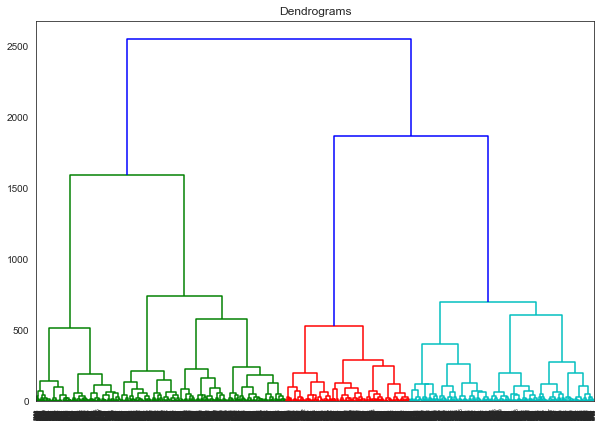

In [109]:
dendrogram_genetator(vec_df)

In [110]:
def dendrogram_genetator_with_thresold(df,thresold):
    plt.figure(figsize=(10, 7))
#     y=800
    plt.title("Dendrograms")  
    dend = shc.dendrogram(shc.linkage(df, method='ward'))
    plt.axhline(thresold, color='r', linestyle='--')
    


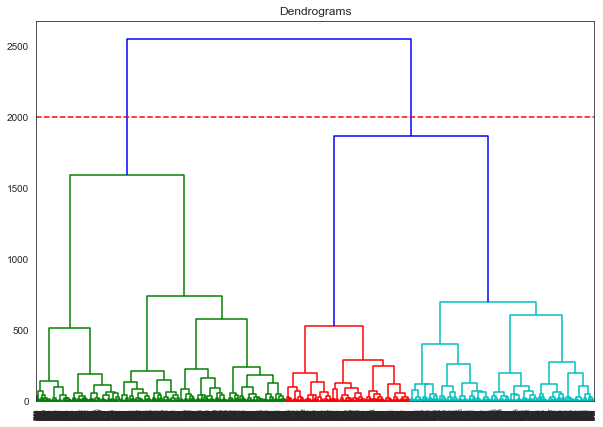

In [111]:
dendrogram_genetator_with_thresold(vec_df,2000)

In [112]:
def hierarchial_clustering(df):
    cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')  
    cluster.fit_predict(df)
    
    plt.figure(figsize=(10, 7))  
    plt.scatter(df['ft1'], df['ft2'], c=cluster.labels_) 
    

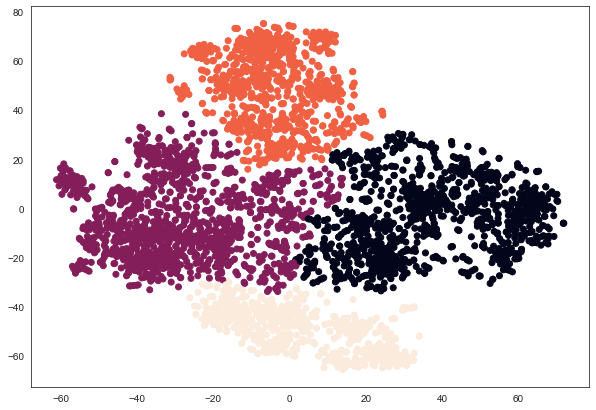

In [113]:
hierarchial_clustering(vec_df)

In [114]:
#result.reset_index(drop=True, inplace=True)
vec_df.set_index(review_text_df["Review Text"], inplace = True) 
vec_df

ft1        ft2
Review Text                                                             
best app 4 students                                -42.143665 -12.574281
app usefull students teachers                      -37.078617 -19.710718
work mobile even android 73                          3.441870  39.101883
good app secondary school teacher notice dixa s... -41.737804 -18.006393
good app lean                                        2.294305  48.784451
...                                                       ...        ...
app good app                                       -12.349454  51.928226
please complete content early                       29.738007  30.074114
good best learn app                                -35.791798  11.764536
super excellent extraordinariy                      63.021172  -2.552460
instal app bar code hsc text bookeven commencem... -21.018427 -28.398001

[4053 rows x 2 columns]


# Element extraction from clusters


In [115]:
def cluster_element_extraction(vec_df):
    sns.set_palette('Set1', 10, 0.65)
    palette = (sns.color_palette())
    #set_link_color_palette(map(rgb2hex, palette))
    sns.set_style('white')
    
    np.random.seed(25)
    
    link = linkage(vec_df, metric='correlation', method='ward')

    figsize(8, 3)
    den = dendrogram(link, labels=vec_df.index)
    plt.xticks(rotation=90)
    no_spine = {'left': True, 'bottom': True, 'right': True, 'top': True}
    sns.despine(**no_spine);

    plt.tight_layout()
    plt.savefig('feb2.png');
    
    cluster_idxs = defaultdict(list)
    for c, pi in zip(den['color_list'], den['icoord']):
        for leg in pi[1:3]:
            i = (leg - 5.0) / 10.0
            if abs(i - int(i)) < 1e-5:
                cluster_idxs[c].append(int(i))
                
    class Clusters(dict):
        def _repr_html_(self):
            html = '<table style="border: 0;">'
            for c in self:
                hx = rgb2hex(colorConverter.to_rgb(c))
                html += '<tr style="border: 0;">' \
                '<td style="background-color: {0}; ' \
                           'border: 0;">' \
                '<code style="background-color: {0};">'.format(hx)
                html += c + '</code></td>'
                html += '<td style="border: 0"><code>' 
                html += repr(self[c]) + '</code>'
                html += '</td></tr>'

            html += '</table>'

            return html
    
    cluster_classes = Clusters()
    for c, l in cluster_idxs.items():
        i_l = [den['ivl'][i] for i in l]
        cluster_classes[c] = i_l
        
    return cluster_classes
    

<ipython-input-115-b873e6abbf3f>:17: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 



{'g': ['easy grasp rhyme enjoyable easy teach need information grammar ',
  'good easy childern ',
  'cant get languages except telugu ',
  'app best app till give 4 star subject lessons explanation plz keep explanation sanskrit ete love app ',
  'good lesson plan ',
  'helpful little content add ',
  'exceed expectations issue minor spell grammatical errors question answer good initiative ',
  'class 11 new syllabus maharashtra get print ',
  'useful easy revision ',
  'good bad sometimes ',
  'like app much helpful non experience teacher new syllabus 2nd std maharashtra board please anyone read msg please tell 2nd std new syllabus go come app ',
  'exlent useful evey children ',
  'bohot acha app hai ',
  'good cant explain word ',
  'need improvement sanskrit ',
  'good keep go like ',
  'need 11 science content ',
  'useful every studentlots content help understand key concept behind every chaptersbetter learn style adopt tutor teach thereand amaze ap ',
  'best easy learn ',
  'good education knowapp ',
  'jab mai ne yeh app start kiya toh nhi ho raha tha pta nhi kyu idk im disappoint ',
  'useful tool teacher teach effortful understand ',
  'useful students also teachers ',
  'find marathi aksharbharti class 10th ',
  'usefuli happy use this ',
  'pupils completely understand involve lesson ',
  'easy understand concept ',
  'nice learn odia ',
  'good explain doubt ',
  'excellent application student self study ',
  'give idea study help education ',
  'good critical think practice ',
  'good really like please try ',
  'best pseb students ',
  'superb study well ',
  'badiya hai ye aap ',
  'app indias best e learn app everyone like app mostly thank diksha app create best powerful app students teachers ',
  'help lot studiesthanks government ',
  'safe nc 2 learn std 678 ',
  'batter add mp bord ',
  'dumbbell didi sick sick cool ',
  'oh full go ',
  'good teach learn ',
  'teach method veri good ',
  'good aai use class room ',
  'excellent word sayfantastic ',
  'superrrr see one lesson best option childrens ',
  'important us useful us ',
  'good question give information basics chapter ',
  'naku nacha ledu ',
  'ssc board maharstra 10 11 app download app hindi subject chapter app launch app subject chapter app chapters ',
  'ok sure rehan ',
  'ok good children ',
  'use 10th students help score highest mark board exam ',
  'nice love much ',
  'excellent platform students teachers increase pace joyful learn ',
  'arun kashyap vk ',
  'good understand lessons ',
  'haha hi xy ',
  'help students understand better ',
  'good useful children ',
  'manya shree h ',
  'good aap teachers ',
  'spell midnightvisitor wrongly spell visiter ',
  'good practice wd solutions ',
  'like elaborative note english textbookthanku much diksha team ',
  'good aap students ',
  'slow sing song read ',
  '11th class maharastra bords thing available give 1star please upload something ',
  'kindly add pdf book primary basic education uttar pradesh ',
  'bahut bekar app hai koi leasson milta hi nhi bcho ko pdhane k liye 1st class k bcho k liye kuch nhi h ',
  'best video 1 class ',
  'help children learn ',
  'best 4 u ',
  'really good students read improve logical think ',
  'useful effective teachers studendts ',
  'app use full government india ',
  'awesome way teach class interest sound low ',
  'uploding contet evs class 3 cg board pleas check ',
  'great step eduction ',
  'easy learn thank diksha thank ',
  'amaze thank much help ',
  'super app tamilnadu ',
  'this helpful school ',
  'good make easy understand ',
  'ku mister majnu ',
  'supper good correct ',
  'digital copy text book ',
  'e content regard class 9 plz available ',
  'nice nice nice nice nice ',
  'hi aim shahul hand ',
  'need chapters relate video class 10 mathematics try upload soon possible ',
  'install app score good mark like app learn concentration important get confidence back tq help dont forget app definitely ',
  'give good clarity students unde

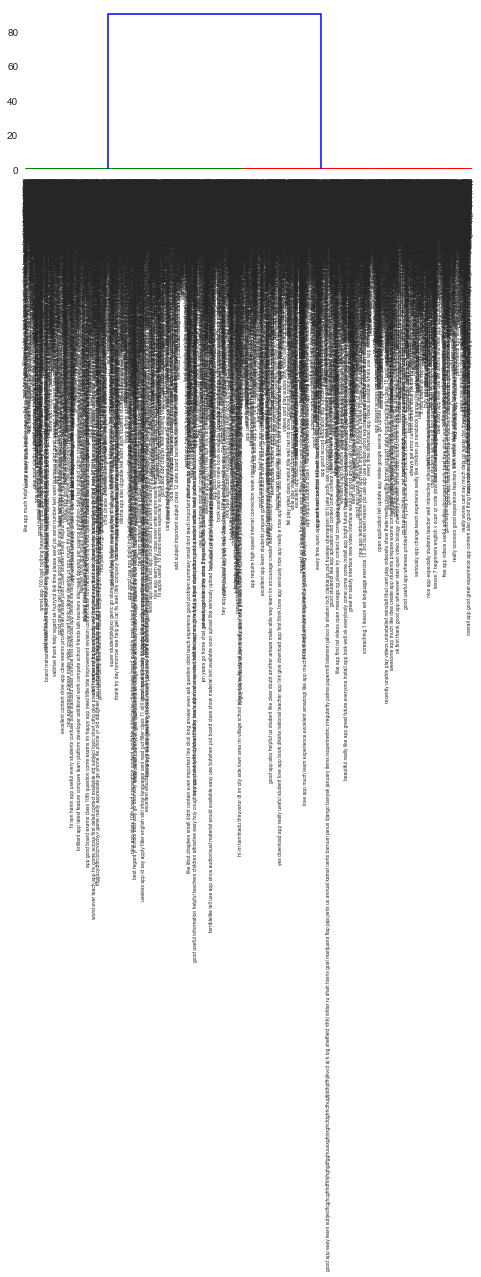

In [116]:
cluster_element_extraction(vec_df)


# Element extraction from clusters for each rating


In [117]:
def clustering_rating_wise(key_rate_df, rating):
    key_data = key_rate_df.loc[key_rate_df['Star Rating'] == rating]
    key_rate_df1 = pd.DataFrame(key_data)
#     return key_rate_df1
    ky_ls =key_rate_df1['Review Text'].tolist()
    
    frame = vectorization_of_list(ky_ls)
    frame.set_index(key_rate_df1["Review Text"], inplace = True) 
    return cluster_element_extraction(frame)

In [118]:
def keyword_freq_per_cluster(cluster_elem, cluster_no):
    #changing to lower order
    out = map(lambda x:x.lower(), cluster_elem)  
    elem_lower = list(out)  
    #print(output) 
    #Creating a new Dtaframe which is required for final csv
    df_rate_c = pd.DataFrame(columns=['Review Text', 'Keywords', 'Cluster'])

    for i in elem_lower:
        if(i == ''):
            df_rate_c = df_rate_c.append({'Review Text': i, 'Keywords': '[]', 'Cluster': cluster_no}, ignore_index=True)
        else:
            x = phrase_extraction(i, grammar)
            df_rate_c = df_rate_c.append({'Review Text': i, 'Keywords': x, 'Cluster': cluster_no}, ignore_index=True)
    
    ky_ls = (df_rate_c['Keywords'].tolist())
    ky_ls_df = pd.DataFrame(ky_ls)
    return ky_ls_df[0].value_counts()[:30]


# cluster analysis for rating 5 - elements of cluster, wordcloud, frequency of most frequent words that are appearing


<ipython-input-115-b873e6abbf3f>:17: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 



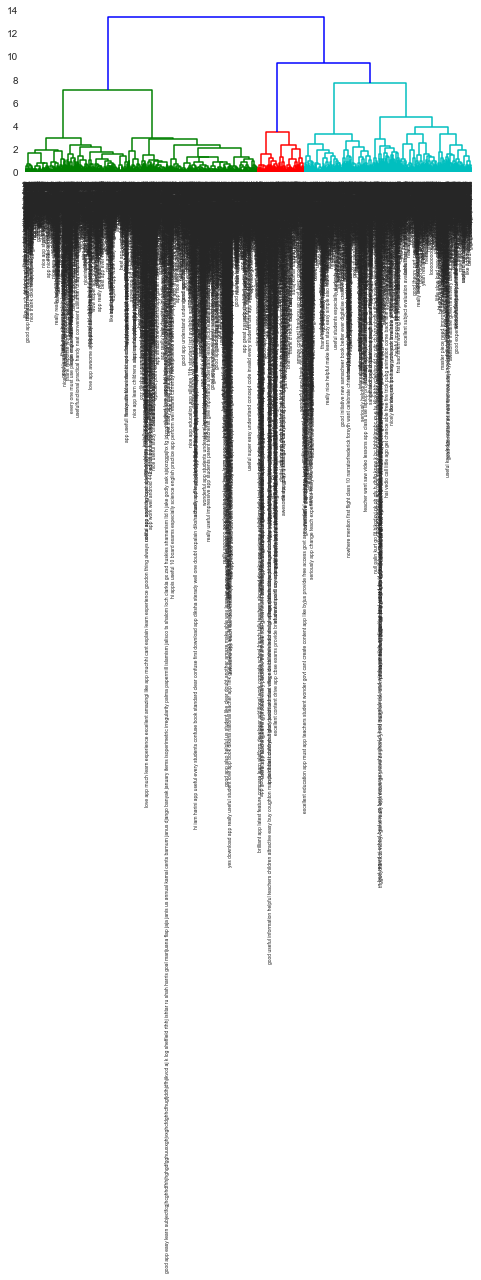

In [119]:
elem_rate5 = clustering_rating_wise(initial_df, 5)

In [120]:
g5_elem = elem_rate5['g']


['thank app help learn new things thank ',
 'app good learn things thank ',
 'thank diksha app learn quickly easly ',
 'like much understand lesson etc thank dikesha app create sir ',
 'helper app thank lot ',
 'many thank app helpful ',
 'helpfull app thank ',
 'thank much much app ',
 'fabulous app learnerstruly helpful really appreciate ',
 'osam app love thank much ',
 'good app thank ',
 'app nice thank ',
 'thank thank much good app ',
 'great app thank much ',
 'useful app thank u ',
 'wow nice thank app ',
 'good app thanku much ',
 'nice helpful want improvements app thank ',
 'nice app really helpful good creativity content much appreciate ',
 'good app thank u make woundreful app take much time lod also like app ',
 'thank app make ',
 'thank make app ',
 'thank provide app ',
 'thank give app ',
 'thank sir make app ',
 'thank make like apps ',
 'thank app useful life ',
 'thank u help worlds best app ',
 'thank app amaze app appreciate ',
 'thank u app ',
 'thank thus app 

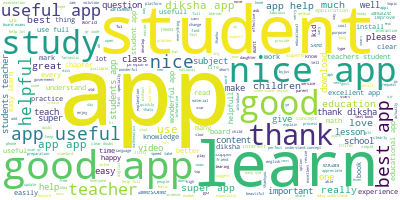

In [121]:
from wordcloud import WordCloud

#text = list(eng_df['Review Text'])
long_string = ','.join(g5_elem)
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

In [123]:
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
import re

def leaves(tree):
    """Finds NP (nounphrase) leaf nodes of a chunk tree."""
    for subtree in tree.subtrees(filter = lambda t: t.label()=='NP'):
       # The yield statement suspends function’s execution and sends a value back to the caller.
        yield subtree.leaves()

def acceptable_word(word):
    """Checks conditions for acceptable word: length, stopword."""
    accepted = bool(2 <= len(word) <= 40
                    and word.lower() not in stopwords)
    return accepted

def get_terms(tree):

    for leaf in leaves(tree):
        term = [ w for w,t in leaf if acceptable_word(w) ]
        yield term


In [124]:
keyword_freq_per_cluster(g5_elem,1).to_dict()

{'app': 115,
 'nice': 20,
 'good app': 13,
 'students': 12,
 'diksha app': 11,
 'useful app students': 11,
 'useful': 8,
 'much': 7,
 'help': 7,
 'study': 6,
 'nice app': 6,
 'useful app': 6,
 'good': 5,
 'good app learn': 5,
 'good app students': 5,
 'helpful': 4,
 'great app': 4,
 'learn': 4,
 'superb': 4,
 'educational app': 4,
 'learn app': 4,
 'children': 4,
 'app students teachers': 4,
 '': 4,
 'apps': 3,
 'useful students': 3,
 'diksha': 3,
 'app learn': 3,
 'education': 3,
 'study app': 3}

In [125]:
import re
g5_most_frequent = [y for y in g5_elem if re.search('good app', y)]


['good app thank ',
 'thank thank much good app ',
 'good app thanku much ',
 'good app thank u make woundreful app take much time lod also like app ',
 'good experience also good app ',
 'good app really enjoy ',
 'really good app ',
 'verry good app ',
 'good app awesome ',
 'good app superb ',
 'excellent good app ',
 'good app nice app ',
 'nice simply vrey good app ',
 'good app excellent work ',
 'good app nice ',
 'thats good app ',
 'good app like much ',
 'good app explaning clearly ',
 'good app love ',
 'mm good app love ',
 'good app good learn ',
 'good app learn ',
 'good app l learn ',
 'good app e learn ',
 'good app practice ',
 'nice app like app videos nice fast engilsh good app thank app creater ',
 'good app nice video ',
 'good app sometimes show videos ',
 'good app lean ',
 'app vgood app ',
 'diksh app si good app ',
 'really good app 10th std learners ',
 'good app stds scan qr cod ',
 'good app love app ',
 'app good app helpful app love app ',
 'wow super ap

In [126]:
r5_elem = elem_rate5['r']


['nice app tamil ',
 'nice app hindi course class 10 ',
 'nice app tamilnadu text book ',
 'wonderful app tamil study ',
 'nice app kendriya vidyalaya students ',
 'nice app students student odisha ardashar vidyalaya ',
 'nice app mhrd cbse ',
 'nice app cbse students teachers ',
 'nice app ncert students ',
 'nice app sree carvery school listen app scan read test nice download slow ',
 'nice app app ncert chapters nicely explain ',
 'awasome app explain douts clear iit ',
 'mohammad ammar app good app study ',
 'government india thank make app help app able make study even better like app much ',
 'useful state board sutdents karnataka state board parent say improve study use app ',
 'really useful app tamilnadu students along app improve study definitely internet access discomfort afford ',
 'make india lovely app provide online education students country boost indian education system provide access wonderful creation ',
 'brilliant app latest feature compare learn platform developer

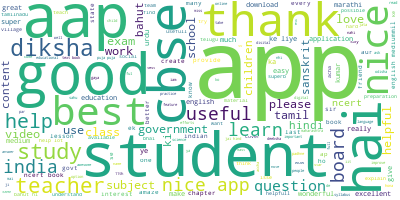

In [127]:
from wordcloud import WordCloud

#text = list(eng_df['Review Text'])
long_string = ','.join(r5_elem)
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

In [128]:
keyword_freq_per_cluster(r5_elem,2).to_dict()

{'study': 4,
 'app': 3,
 'nice learn aap': 2,
 'nice': 2,
 'help': 2,
 'students': 2,
 'much': 2,
 'book tamil': 2,
 '': 2,
 'isse hamaara noleg badhtaa hai sawaalo kejawab jaldi mil jaatahai': 1,
 'vaishnavi gopi lakshmi': 1,
 'bhai ab aur kya chahiyematlab saara ka saara syllabus cover ho': 1,
 'aap teach learn': 1,
 'good odisha goment': 1,
 'good aap kid': 1,
 'class': 1,
 'helpful student cbse': 1,
 'nice app cbse students teachers': 1,
 'use ful aap': 1,
 'wonderful experience outstanding aap': 1,
 'phadu aap paas ho jaoge abhi download karo': 1,
 'board': 1,
 'nice aap varey usfull aap help full stedy': 1,
 'nice app hindi course class': 1,
 'learn aap': 1,
 'excite excellent app govt': 1,
 'sanskrit social': 1,
 'sir please': 1,
 'vishal kumar jila balrampuri': 1,
 'thank lekin laguage hindi hona tha': 1}

In [129]:
import re
r5_most_frequent = [y for y in r5_elem if re.search('india', y)]


['government india thank make app help app able make study even better like app much ',
 'make india lovely app provide online education students country boost indian education system provide access wonderful creation ',
 'brilliant app latest feature compare learn platform developer additional work compete school friends talk teachers also need develop per science exhibition daily test subject option preparation iit medical last think would option compete talk friends india make project friends india jai hind bharat mata ki jai ',
 'indias best learn app ',
 'app indias best e learn app everyone like app mostly thank diksha app create best powerful app students teachers ',
 'good app good user interface havent see indian educational app like ',
 'useful app teachinglearning process every placetime think thank ncte government india one problem find diksha isnt support old version android many people use old version android village india many students couldnt use diksha might try someth

In [130]:
c5_elem = elem_rate5['c']


['matter government introduce new technology every day children helpful make india digitize children get easy read text well app ',
 'weapon mass education new india develop innovations ',
 'good application must implement state school also give education india higher field provide employment digital concern ',
 'excellent education app must app teachers student wonder govt cant create content app like byjus provide free access govt army wonderful experience teacher create content regional languages govt engage teachers create content instead give election duties byjus big diksha app cant ',
 'free cost content make teachers around india ',
 'use government higher secondary school students ',
 'good effort improve education system ',
 'wonderful work government expect kind things childhood miss future generations get benefit ',
 'good initiative start govt provide teachers train regard different school syllabus large quality course train teachers also help students understand school sy

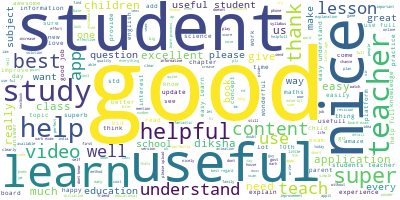

In [131]:
from wordcloud import WordCloud

#text = list(eng_df['Review Text'])
long_string = ','.join(c5_elem)
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

In [132]:
keyword_freq_per_cluster(c5_elem,3).to_dict()

{'students': 15,
 'nice': 13,
 'good': 12,
 'help': 9,
 'good students': 8,
 'useful students': 7,
 '': 5,
 'teachers': 5,
 'super': 5,
 'board': 4,
 'std': 4,
 'good study': 4,
 'class': 4,
 'useful': 4,
 'need': 3,
 'learn': 3,
 'useful study': 3,
 'use full': 3,
 'job': 3,
 'much helpful': 3,
 'superb': 3,
 'helpful': 3,
 'good job': 3,
 'use': 3,
 'much': 3,
 'helpful interact': 2,
 'pseb students': 2,
 'answer': 2,
 'useful students teachers': 2,
 'th class': 2}

In [133]:
import re
c5_most_frequent = [y for y in c5_elem if re.search('good students', y)]


['really good students read improve logical think ',
 'good students teacher ',
 'good students teachers well ',
 'good students nothing teachers ',
 'good students learn well also get knowledge ',
 'good students good studdie better understand ',
 'good students study understand ',
 'good students easily understand ',
 'good students easy understand subject ',
 'really good students ',
 'good students teachersi use study purpose ',
 'good students prepare exams ']


# cluster analysis for rating 4 - elements of cluster, wordcloud, frequency of most frequent words that are appearing


<ipython-input-115-b873e6abbf3f>:17: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 



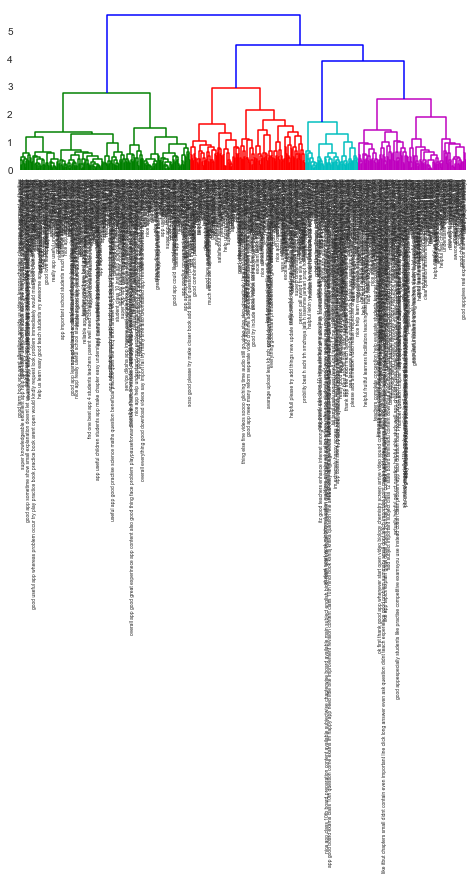

In [134]:
elem_rate4 = clustering_rating_wise(initial_df, 4)

In [135]:
g4_elem = elem_rate4['g']


['good learn app book qr scanner ',
 'great app download text book ',
 'good term book app want alterations provide us videos lessons chapters please see government authorities ',
 'good app learn chapter ',
 'app nice easy learn app learn chapters easily ',
 'super knowledgeable excellent app help quite study useful cct practice also give many question answer note chapters quite helpful ',
 'good learn think better byjus apps app everything like long answer videos chapters etccc ',
 'usefull brother chapter clear nice app ',
 'helpful useful app like meera say contain small chapters include important line pls make sure ',
 'really nice app me chapter divide many part part small please make better ',
 'good app sometime show small explanation doesnt let us understand whole chapter 50 percent chapter also want solution every question dont understand ',
 'good app enough video chapters ',
 'like app chapters available small ',
 'awesome app keep prepare board cant download pdf file quest

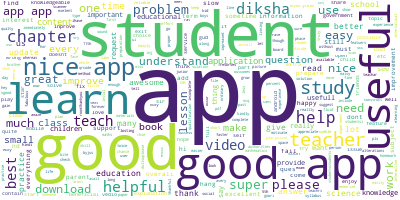

In [136]:
from wordcloud import WordCloud

#text = list(eng_df['Review Text'])
long_string = ','.join(g4_elem)
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

In [137]:
keyword_freq_per_cluster(g4_elem,1).to_dict()

{'nice': 9,
 'app': 8,
 'good app': 3,
 'nice app': 3,
 'good app teachers': 2,
 'star': 2,
 'teach': 2,
 'videos': 2,
 'diksha app': 2,
 'nice app students': 2,
 'overall everything good download videos': 1,
 'great useful app': 1,
 'nice app study': 1,
 'good app teachar student': 1,
 'dont word app': 1,
 'exelent app': 1,
 'lessons interest install app learn': 1,
 'app video work': 1,
 'ok': 1,
 'good helpful app': 1,
 'content': 1,
 'much useful app': 1,
 'ive see': 1,
 'knowledgeable apps children': 1,
 'teach learn': 1,
 'nice app direct': 1,
 'nice work': 1,
 'student good app picture': 1,
 'nice apps sir': 1,
 'good useful app': 1}

In [138]:
import re
g4_most_frequent = [y for y in g4_elem if re.search('good app', y)]


['good app learn chapter ',
 'good app sometime show small explanation doesnt let us understand whole chapter 50 percent chapter also want solution every question dont understand ',
 'good app enough video chapters ',
 'awesome app keep prepare board cant download pdf file question paper would 5 star still good app ',
 'well learn easy good app rat 4 star ',
 'easy learn good app ',
 'think good app one learn things use app ',
 'good app learn teach ',
 'good app self learn teach ',
 'good app learn easyly ',
 'good app good students ',
 'good app teachar student ',
 'good app rbse students ',
 'good apps student learn ',
 'good app class 5th ',
 'good app need much learn videos class 10 science mathematics ',
 'good app learn need lessons social science tell topics teach full lesson person great way success ',
 'app good teacher student user phace good app give proper sulation every chapters ',
 'good app add 11th scc syllabus science ',
 'good app also helpful also interest students 

In [139]:
r4_elem = elem_rate4['r']


['good really like please try ',
 'gud try keep update regard n best wish ',
 'soso good please try make closer book add textual question proper answer please reply soon possible ',
 'next time come detail information ',
 'good usefulbut need update ',
 'need detail descriptions concepts ',
 'good combination picture sound correct informations ',
 'super vary helpfull ',
 'super duper helpful ',
 'helpful know subject ',
 'good job really helpful us ',
 'helpfull studentsnice one ',
 'useful easy one ',
 'good useful one ',
 'good use properly ',
 'okay nad easy use ',
 'better experence fun ',
 'nice creative ideas ',
 'clear subject wise topic need op ',
 'important study question useful ',
 'goodbut question answer available ',
 'good type question answer sweetable new patten ',
 'good long answer vedeo work properly ',
 'much elaborate explanations quite useful relate question ',
 'good learn thing dont know ',
 'nice confusion occur ',
 'goodi understand easily ',
 'understand sub

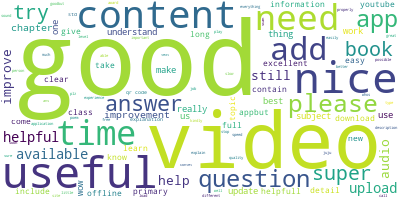

In [140]:
from wordcloud import WordCloud

#text = list(eng_df['Review Text'])
long_string = ','.join(r4_elem)
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

In [141]:
keyword_freq_per_cluster(r4_elem,2).to_dict()

{'good': 5,
 'nice': 4,
 'goodbut question answer available': 2,
 'help': 2,
 'helpful': 2,
 'detail information': 1,
 'experence fun': 1,
 'load process': 1,
 'useful people': 1,
 'learningapp': 1,
 'time sound low': 1,
 'app': 1,
 'good download pdf': 1,
 'useful easy one': 1,
 'good score easy mark': 1,
 'attractive material require': 1,
 'great understandability': 1,
 'describe mean poem': 1,
 'upload videos youtube': 1,
 'super excellent extraordinariy': 1,
 'useful type lerners': 1,
 'upbasic available lessonplan book': 1,
 'little bite': 1,
 'good experience content': 1,
 'good continuation class': 1,
 'highlight line audio': 1,
 'std thank': 1,
 'im able give': 1,
 'good contain variety book': 1,
 'clear subject wise topic': 1}

In [142]:
import re
r4_most_frequent = [y for y in r4_elem if re.search('goodbut question answer available', y)]


['goodbut question answer available ', 'goodbut question answer available ']

In [143]:
c4_elem = elem_rate4['c']


['probility best h achi trh smzhaya jata h issehme jankari prapt hoti h tha 11 anko ki trh smzhaya jata h ',
 'please help mere pass net kam hai ',
 'subject ke lesson ki ',
 'shi hai kammm ka ',
 'khoop chan survaat aahe ',
 'halpful lekin ye video ke wajah likha hua hota aur samjh ata thik hai ',
 'mestan hal old ho chuke hai ab rotavater aa gaya hai ',
 'alsi shikshak aap ',
 'ghani futara aap ',
 'bahut achcha hsin ',
 'bahut hi achha ',
 'mughe achcha laga ',
 'hindi kaise sikhaye koi saral tarika bataye ',
 'bahut hi achha ',
 'nice thoda problem ho raha hai sorry ',
 'good plan tamil nadu government easy lean ',
 'best helpfull aap ',
 'good aap students ',
 'best education aap ',
 'aap improve education system ',
 'itz good teachers enhance interest among aapirants various class rajneesh kumar pandey up babhnanpurwa gorahiya 1 kaisarganj bahraich uttar pradesh ',
 'aap good upto class 10 since student year go class 11 upgrade upto class 12 oterwise good appkeep guy well do ',
 

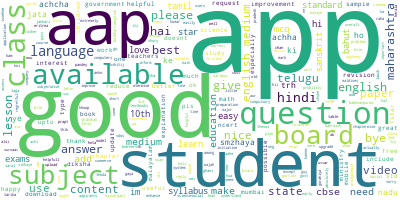

In [144]:
from wordcloud import WordCloud

#text = list(eng_df['Review Text'])
long_string = ','.join(c4_elem)
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

In [145]:
keyword_freq_per_cluster(c4_elem,3).to_dict()

{'app': 4,
 'class': 3,
 'bahut hi achha': 2,
 'telugu lessons': 2,
 'mughe achcha laga': 1,
 'aap im student please use aap': 1,
 'ok english sanskrit hindi yes': 1,
 'content std11 state maharashtra english medium': 1,
 'possible': 1,
 'th std maharashtra state commerce course ne': 1,
 'nice thoda problem ho raha hai sorry': 1,
 'helpfull aap': 1,
 'nice learn odia': 1,
 'education system': 1,
 'india mobiles': 1,
 'interest': 1,
 'good ncert students': 1,
 'themas government application': 1,
 'learn app kerala syllabus': 1,
 'upload subject question paper': 1,
 'board': 1,
 'shi hai kammm ka': 1,
 'khoop chan survaat aahe': 1,
 'subject ke lesson ki': 1,
 'important': 1,
 'great work cbse lauch diksha app': 1,
 'free': 1,
 'board preparation content available subjectwise chapterwise board available main subject english hindi math science social': 1,
 'standard vdos cbse': 1,
 'alsi shikshak aap': 1}

In [146]:
import re
c4_most_frequent = [y for y in c4_elem if re.search('teachers', y)]


['itz good teachers enhance interest among aapirants various class rajneesh kumar pandey up babhnanpurwa gorahiya 1 kaisarganj bahraich uttar pradesh ',
 'app good learners teachers subject except computers english medium telugu medium users understand easily free cost doesnt lesson 110 class ',
 'good app children teachersplease translate hindi every lesson ']


# cluster analysis for rating 3 - elements of cluster, wordcloud, frequency of most frequent words that are appearing


<ipython-input-115-b873e6abbf3f>:17: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 



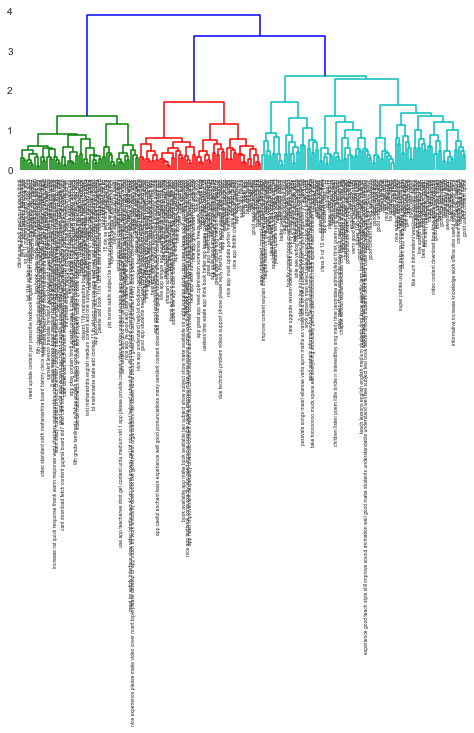

In [147]:
elem_rate3 = clustering_rating_wise(initial_df, 3)

In [148]:
g3_elem = elem_rate3['g']


['aap learner enjoyand learn interest ',
 'kuch lessons pending hain ',
 'diksha aap hindi medium students think ',
 'need update content per prescribe textbook english medium state board maharashtra 9th standard ',
 'subject book available odia medium ',
 'tell 11th syllabus content come maharashtra state bord ',
 'sir till 11 maharashtra board book add ',
 'two book class mybe good l hindi medium class 9th ',
 '8th class tak hindi medium walo ki book hi nhi haistate rajasthan medium hindi ',
 'add book punjabi medium ',
 'video standard sixth maharashtra board history civics subject lesson 9 ancient kingdoms south available kindly fix early possible thank ',
 '11th class videos come board maharashtra medium semi english u able subject ',
 'please best video quality indias best teacher insert diksha pleplepleplease ',
 'sanskrit lesson translate hindiand worksheet add question from burgess cgbsce 10th class ',
 'show question math 1and 2 class 10 maharashtra board ',
 'find marathi ak

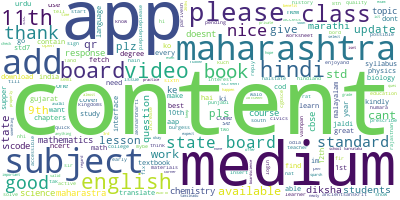

In [149]:
from wordcloud import WordCloud

#text = list(eng_df['Review Text'])
long_string = ','.join(g3_elem)
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

In [150]:
keyword_freq_per_cluster(g3_elem,1).to_dict()

{'book punjabi medium': 1,
 'book': 1,
 'state board maharashtra': 1,
 'time board hope chapters': 1,
 'much tht work': 1,
 'app please': 1,
 'good please': 1,
 'subject book available odia medium': 1,
 'diksha aap hindi medium students': 1,
 'compulsory': 1,
 'good app jisse hame prkar ki suvida multi nice supper supper good': 1,
 'kya soch ke banaya kisi kam ka ni': 1,
 'iam kerala': 1,
 'th std soo cant use app study': 1,
 'class': 1,
 'maharashtra board book': 1,
 'want study materials physics': 1,
 'maharashtra boardscience subjectsenglish medium content': 1,
 'hindi content english': 1,
 'marathi aksharbharti class': 1,
 'board marathi subject answer give cant open anything': 1,
 'saath': 1,
 'din se technical fault bta raha': 1,
 'ancient kingdoms': 1,
 'aap learner enjoyand learn interest': 1,
 '': 1,
 'app doesnt offer practice question hindi course course available pls check': 1,
 'subject plz reply college start': 1,
 'chemistry': 1,
 'maharashtra state code': 1}

In [151]:
import re
g3_most_frequent = [y for y in g3_elem if re.search('add class st state board maharashtra', y)]


[]

In [152]:
r3_elem = elem_rate3['r']


['okay learn improve download facilities good app ',
 'good app students need load content video lessons need improve good effort ',
 'nice app understand help lot lockdown problem face internet could make videos offline ',
 'simple yet effective app help students brush concepts ',
 'like app much learn mind bloing app simple app ',
 'useful app use us pioneer know concept easier manner ',
 'good app help learn standara thank launch app ',
 'best app learn poems available explanation like app ',
 'app good englishsanskritsocial science hindi book solutions available ',
 'app useful enchant learn experience well good pronunciations many sanskrit content download new language students already download thank government app ',
 'sharvari sontakke app useful students teachers like app ',
 'app best ti use full app students teachers ',
 'really good app app type syllabus class book ',
 'one best app fr educational purpose ',
 'love app amaze app super fentasitik students use app ',
 'app use

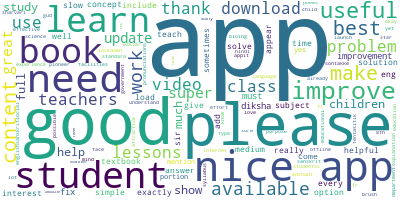

In [153]:
from wordcloud import WordCloud

#text = list(eng_df['Review Text'])
long_string = ','.join(r3_elem)
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

In [154]:
keyword_freq_per_cluster(r3_elem,2).to_dict()

{'app': 6,
 'nice': 4,
 'great app option': 2,
 'great app': 2,
 'portion mention please update': 2,
 'good answer wrongi': 1,
 'super duper app': 1,
 'improvement': 1,
 'effective app help students brush concepts': 1,
 'nice app app useful children': 1,
 'star learn app': 1,
 'excellent diksha app': 1,
 'satisfactory': 1,
 'app hang please': 1,
 'ok app': 1,
 'super app diksha': 1,
 'solution': 1,
 'videos': 1,
 'good app students': 1,
 'app work show': 1,
 'hi super app': 1,
 'useless time waste': 1,
 'manner': 1,
 'useful app yes': 1,
 'download content need': 1,
 'download facilities good app': 1,
 'app diksha': 1,
 'good englishsanskritsocial science hindi book solutions available': 1,
 'app work android tv': 1,
 'thank government app': 1}

In [155]:
import re
r3_most_frequent = [y for y in r3_elem if re.search('easy learn', y)]


[]

In [156]:
c3_elem = elem_rate3['c']
c3_elem

['easy understand concept try improve animation ',
 'improve content explain briefly explanation examples need clearity video ',
 'itsgood videos available ',
 'plan youtube youu3be videos ',
 'helpful reason im give 3 star videos available ',
 'please upload 9 std subject videos ',
 'application nice 11th std content add yet ',
 'please add videos ',
 'better please upload videos ',
 'need update videos ',
 'please update term two videos class 2 ',
 'cant see document topic ',
 'cant play video content ',
 'unable scan qr code ',
 'helpfulbut qr scan code work ',
 'new upgrade version scanner work properly please something regard ',
 'able see vedios offline able download vedios ',
 'scan process load pls see ',
 'bug fix content book cover available give reason ',
 'paravala songs maari ellamae varla aprm maths ex varala adhu ennaku pudikala innum improve aganum try ur level bst ',
 'start 3 star ',
 '3 star stop log ini hope developer fix friends really nice students ',
 'work prope

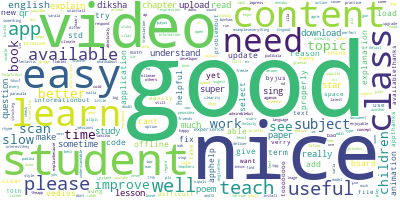

In [157]:
from wordcloud import WordCloud

#text = list(eng_df['Review Text'])
long_string = ','.join(c3_elem)
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

In [158]:
keyword_freq_per_cluster(c3_elem,3).to_dict()

{'nice': 4,
 'students': 3,
 'good': 2,
 'good apphelp informationbut file availablethanks': 2,
 'easy learn': 2,
 'videos': 2,
 'friendly interface': 1,
 'helpful reason im': 1,
 'bonham app nalla illa pa': 1,
 'class': 1,
 'superb study': 1,
 'good good good': 1,
 'nice helpful sutdy': 1,
 'poor kind service': 1,
 'good learn verry easy study': 1,
 'siddh vilas pilane': 1,
 'varala adhu ennaku pudikala innum': 1,
 'good problem slow network': 1,
 'nice chapters': 1,
 'chapter difficult explainbecause cold freeze climate children': 1,
 'slow sing song read': 1,
 'topic': 1,
 'decent slow useful': 1,
 'come': 1,
 'good way teach': 1,
 'easy understand concept try': 1,
 'star': 1,
 'nice fulll detail': 1,
 'doubt sessions': 1,
 'good nice learn': 1}

In [207]:
import re
c3_most_frequent = [y for y in c3_elem if re.search('nice', y)]


['application nice 11th std content add yet ',
 '3 star stop log ini hope developer fix friends really nice students ',
 'nice chapters 8 english available ',
 'really nice one ',
 'nice fulll detail ',
 'good nice suoer ',
 'nice like byjus ',
 'nice strucking type ',
 'nice love much ',
 'nice subject also mah board ',
 'good nice learn easly ',
 'nice helpful sutdy ']


# cluster analysis for rating 2 - elements of cluster, wordcloud, frequency of most frequent words that are appearing


<ipython-input-115-b873e6abbf3f>:17: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 



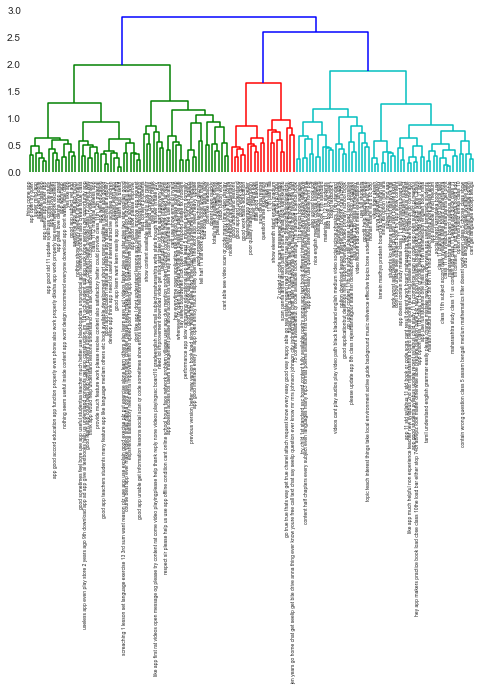

In [160]:
elem_rate2 = clustering_rating_wise(initial_df, 2)

In [161]:
g2_elem = elem_rate2['g']


['thing come app ',
 'app open try open ',
 'available data app ',
 'app usefull app super app ',
 'app open mobile ',
 'super mind app ',
 'app good accord education app function properly even phone also work properly diksha app work properly lag even network excellent ',
 'app great love diksha app great ',
 'app good love faster ',
 'app good std 11 update syallbuss come time study ',
 'app worst app ',
 'nothing seem useful inside content app worst design recommend everyone download app dont waste time data ',
 'good app subject yet add ',
 'awesome appi like app much ',
 'yes like app ',
 'good sometimes feel bore use app useful studentsa teacher much better use blackboardan unpractical app network problem also create issue class ',
 'useless app even play store 2 years ago 9th download app ad app give al textbooks help us understand concepts get app construction im 11th pcb student still app suck hope seniors get opportunity app ',
 'good learn app could help app contain content 

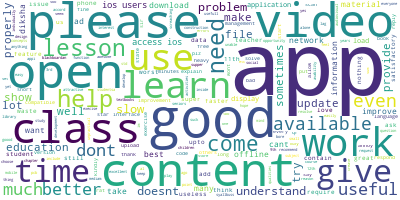

In [162]:
from wordcloud import WordCloud

#text = list(eng_df['Review Text'])
long_string = ','.join(g2_elem)
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

In [163]:
keyword_freq_per_cluster(g2_elem,1).to_dict()

{'class': 4,
 'app': 3,
 'education': 2,
 'free use application': 2,
 'heavy update': 2,
 'minutes': 2,
 'mattr': 1,
 'please fix problem': 1,
 'good love': 1,
 'dont': 1,
 'long time load videos': 1,
 'reply': 1,
 'try open': 1,
 'app open try open': 1,
 'cant use show email id invalid': 1,
 'work': 1,
 'app request': 1,
 'app usefull app super app': 1,
 'class ask question lesson': 1,
 'lead content problems': 1,
 'super mind app': 1,
 'available offline': 1,
 'videos': 1,
 'cant able see video scan qr': 1,
 'good app subject': 1,
 'useful interest attractive activities children': 1,
 'wish': 1,
 'function': 1,
 'learn others': 1,
 'half': 1}

In [164]:
import re
g2_most_frequent = [y for y in g2_elem if re.search('minutes', y)]


['performance app slow camparing educational app take least 5 minutes perform normally ',
 'good app work way slow wait like 20 minutes get ppt load lagapp ']

In [165]:
r2_elem = elem_rate2['r']


['good understand lessons ',
 'good apphard understand ',
 'good work good ',
 'good work basic education ',
 'nicee something cant understand ',
 'super sciens ege ',
 'little good bakwas ',
 'poor quality matterno description ',
 'theteacherapp way better ',
 'sure diksha revirse ',
 'question arise explanation ',
 '11 th pathi illa ',
 'show eleventh stard english madium ',
 '2 upload qr code scan massaege 3j9wtc h5z6ni iujtqi ',
 'scan panna antha lesson pathi ethume varala apdi kamikkuthu ',
 'cute ng hh hb g gnu ',
 'wax sew ca ',
 'super super gundu mudu gundlu feel bite new one fine feel bite new ',
 'jen years go home chat get seelip get bite drive anna thing ever know youre free call text chat say seelip question ever know mr mrs johnson johnson city jndnem jhfjjeie chat later well favourite place favourite thing favourite part ',
 'go true true thats way get true chanel attach request know every easy good way happy able go real estate regard read reviewst true true 5ttteodjd

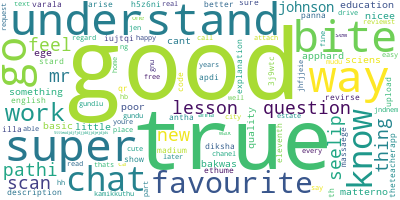

In [166]:
from wordcloud import WordCloud

#text = list(eng_df['Review Text'])
long_string = ','.join(r2_elem)
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

In [167]:
keyword_freq_per_cluster(r2_elem,2).to_dict()

{'cute ng hh hb gnu': 1,
 'english madium': 1,
 'true true': 1,
 'scan panna antha lesson pathi': 1,
 'free call text chat': 1,
 'good work good': 1,
 'upload qr code scan massaege': 1,
 'good work basic education': 1,
 'question arise explanation': 1,
 'wax sew': 1,
 'sure diksha revirse': 1,
 'th pathi illa': 1,
 'good apphard understand': 1,
 'theteacherapp way': 1,
 'fine': 1,
 'ege': 1,
 'good understand lessons': 1,
 'good bakwas': 1,
 'poor quality matterno description': 1,
 'something cant understand': 1}

In [168]:
import re
r2_most_frequent = [y for y in r2_elem if re.search('tamil', y)]


[]

In [169]:
c2_elem = elem_rate2['c']


['75 content availablebut qr code available book strange 7th standerd science book ',
 '11th physics book available ',
 'try child 1st standard ssc board content fully available poetry songs app text book different interactive level require effective ',
 'content half chapters every subject even languages many mp3 format poems available first complete mediums maharashtra ask teachers download thums ',
 'app good easy use question arent downloadable form pdf ',
 'also upload book pdf ',
 'nice english medium course available ',
 'available english medium ',
 'add book cover class ',
 'board textbook r ',
 'materials 11 12 th students ',
 'book 11th standard ',
 'try child 1st standard ssc board content fully available poetry songs app text book different interactive level require effective ',
 'option download lesson internet doesnt work rural school ',
 'good applicationbut desktops hine support download video primary school book ',
 'able download laptop lot struggle ',
 'videos cant 

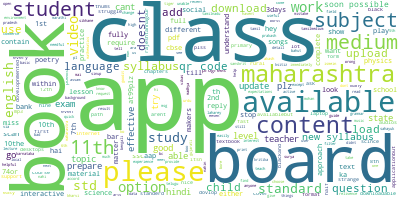

In [170]:
from wordcloud import WordCloud

#text = list(eng_df['Review Text'])
long_string = ','.join(c2_elem)
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

In [171]:
keyword_freq_per_cluster(c3_elem,3).to_dict()

{'nice': 4,
 'students': 3,
 'good': 2,
 'good apphelp informationbut file availablethanks': 2,
 'easy learn': 2,
 'videos': 2,
 'friendly interface': 1,
 'helpful reason im': 1,
 'bonham app nalla illa pa': 1,
 'class': 1,
 'superb study': 1,
 'good good good': 1,
 'nice helpful sutdy': 1,
 'poor kind service': 1,
 'good learn verry easy study': 1,
 'siddh vilas pilane': 1,
 'varala adhu ennaku pudikala innum': 1,
 'good problem slow network': 1,
 'nice chapters': 1,
 'chapter difficult explainbecause cold freeze climate children': 1,
 'slow sing song read': 1,
 'topic': 1,
 'decent slow useful': 1,
 'come': 1,
 'good way teach': 1,
 'easy understand concept try': 1,
 'star': 1,
 'nice fulll detail': 1,
 'doubt sessions': 1,
 'good nice learn': 1}

In [172]:
import re
c2_most_frequent = [y for y in c4_elem if re.search('app', y)]


['aap good upto class 10 since student year go class 11 upgrade upto class 12 oterwise good appkeep guy well do ',
 'app best govt students ',
 'student ncert work ministry education maldives ministry education eritrea refer app students world wow request mou mobile company make compulsory app make india mobiles thank ',
 'diksha app student 6 10 important like cinema ',
 'nice app class 10th board preparation content available subjectwise chapterwise board available main subject english hindi math science social 2000 question overall type question available mcqs short answer question shory answer question ong answer type question give 4 star mcqs chapters available ',
 'learn app kerala syllabus ',
 'app good learners teachers subject except computers english medium telugu medium users understand easily free cost doesnt lesson 110 class ',
 'app good board exams class 10th question come exams im happy app need little bite improvement revision content class 10th hindi book kshitij krit


# cluster analysis for rating 1 - elements of cluster, wordcloud, frequency of most frequent words that are appearing


<ipython-input-115-b873e6abbf3f>:17: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 



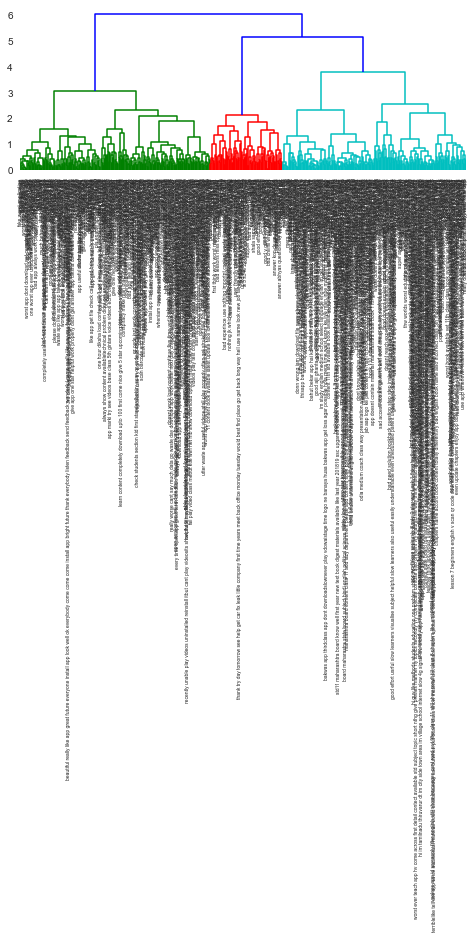

In [173]:
elem_rate1 = clustering_rating_wise(initial_df, 1)

In [174]:
g1_elem = elem_rate1['g']


['worst app ever ',
 'totally worst app ever ',
 'worst app ever see ',
 'worst app forever ',
 'one worst app ',
 'worst app ever never use ',
 'worst app learn ',
 'wrost app ever ',
 'app worst app download byjus enjoy ',
 'worst app waste time download ',
 'worst app dont download net complete get answer donkey app ',
 'worst app result app give logo ',
 'fake worst application ',
 'fake app useful ',
 'one worst app ever usedplease dont instal app become cheat ',
 'worst chance block app lucky app ',
 'bad app game instal useful app pc game ',
 'worst work app mobile ',
 'work wrost app ',
 'work properly hang worst app ',
 'app always hang ',
 'really bad app never think ',
 'bad app world ',
 'good bad app ',
 'bad app use ',
 'bad app thirdclass ',
 'bad app work ',
 'vary bad app ',
 'bad app always work properly helpful emergency ',
 'app usfull content bad ',
 'bad experience worst app ever doesnt explain anything incomplete content ',
 'much behave like cheap app hate ',
 '

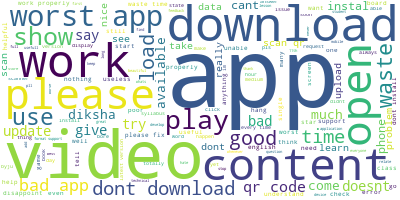

In [175]:
from wordcloud import WordCloud

#text = list(eng_df['Review Text'])
long_string = ','.join(g1_elem)
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

In [176]:
keyword_freq_per_cluster(g1_elem,1).to_dict()

{'app': 22,
 'videos': 7,
 'bad app': 3,
 'work': 3,
 'download': 3,
 'app work': 3,
 'content load': 3,
 'waste app': 2,
 'syllabus change time': 2,
 'nice app': 2,
 'app video content app help fullwaste app': 1,
 'faltu app hetime': 1,
 'app nothing': 1,
 'content book available': 1,
 'scanner work proper scan prblm occur version plz upload new version': 1,
 'app open device bad': 1,
 'app store doesnt allow zero': 1,
 'app work phone': 1,
 'first': 1,
 'show photo bor appp': 1,
 'good work open app show': 1,
 'app horrible useless appsorry': 1,
 'learn': 1,
 'help': 1,
 'app forever': 1,
 'app scan qr code': 1,
 'diksha app bhangar app': 1,
 'many lekkas': 1,
 'wast app': 1,
 'app usfull content bad': 1}

In [177]:
import re
g1_most_frequent = [y for y in g1_elem if re.search('board', y)]


['run properly mi pad kitkat android select board drop menu drop work qr code scanner hang ',
 'download app ans try operate hang bfr cld select board keep click board nothing happen screen get dull whats use cant open ',
 'recently unable play videos uninstalled reinstall itbut cant play videosits show thate media playedfile format support state board tamilnadu class 15 tamil english medium unable play even single video good internet connection view videos ',
 'many videos available still worthless many videos available 1to 8 grade state board english medium ']

In [178]:
r1_elem = elem_rate1['r']


['take lot time load ',
 'slow take longer time work ',
 'work waste time ',
 'useful time consume ',
 'install waste time ',
 'problem work wastage time ',
 'useful content add yet ',
 'content yet ready ',
 'first think work worst nightmare say content add yet ',
 'need soo much improvement ',
 'easy method learn ',
 'useful assistance practice ',
 'practice session work ',
 'bad lessons miss open incomplete waste time ',
 'avery easy learn ',
 'old course video ',
 'matha 7th class ',
 'class 11 12 ',
 '11th 12th class course ',
 'experience badi student ',
 'bad experince use nothing importnt content waste time student well techer w ',
 'waste explaination khan academy best ',
 'good aai use class room ',
 'app good option choose class 11 profile option login ',
 'please add class 11 12 show option ',
 'unable complete profile show option select board option ',
 'class 12 book content available ',
 'class 9 available ',
 'class mention nowhere class available mention class availabl

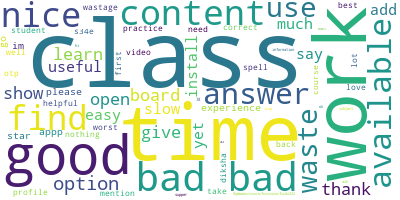

In [179]:
from wordcloud import WordCloud

#text = list(eng_df['Review Text'])
long_string = ','.join(r1_elem)
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

In [180]:
keyword_freq_per_cluster(r1_elem,2).to_dict()

{'class': 4,
 '': 4,
 'work': 2,
 'want information subject': 2,
 'appp': 1,
 'sample paper answer short': 1,
 'time work': 1,
 'superb quality service': 1,
 'wastage data install didnt': 1,
 'bad lessons': 1,
 'noob plz': 1,
 'hi jg jg ge': 1,
 'content': 1,
 'containt available disgust': 1,
 'much bore appp': 1,
 'question': 1,
 'install open work': 1,
 'bad experience use contain chp regard standard': 1,
 'use future': 1,
 'helpful': 1,
 'tousif supar star': 1,
 'bad bad bad bad bad': 1,
 'slow awful relate board': 1,
 'avery easy learn': 1,
 'bad appps vision star': 1,
 'receive otp': 1,
 'hzhgdh fee az az fu sa': 1,
 'good read childern': 1,
 'point': 1,
 'useful time consume': 1}

In [181]:
import re
r1_most_frequent = [y for y in r1_elem if re.search('question', y)]


['please answer question also give ',
 'answer abhyas questiononly show vocabularyi satisfy ']

In [182]:
c1_elem = elem_rate1['c']


['bakwas kam hai ',
 'kuch avible hi nai hai ',
 'hang ho raha hai ',
 'acha nahi hai ',
 'mera diksha nahi khul raha hai ',
 'bahut bakwas hai ',
 'maharashtra kaha hai ',
 'gopi chand sahu ',
 'good aap understand much ',
 'content aap except textbook ',
 'bed savice remove aap ',
 'raj information searchad ',
 'isme rbse board nhi aa raha h plz help me ',
 'maharashtra state board content available ',
 'maharashtra state board class11 content uploded ',
 'content 11th maharashtra state board ',
 '11 th maharashtra board vedio available ',
 'better bihar board ',
 'cant find state board west bengal ',
 'labour india scan ',
 'donn wrong iam download file save phone please give save print 10 th exercise thank diksha o p ',
 'work phone mi note 7pro ',
 'app 11 th maharastra bord standard ',
 'intha app open agamatukuthu naa yappa open panalum diksha nu matum thaa varuthu ',
 'medium board class select nhi ho rha h furji k app na bnaya kre ',
 'thisapp bana diyaor use ktne k loye open 

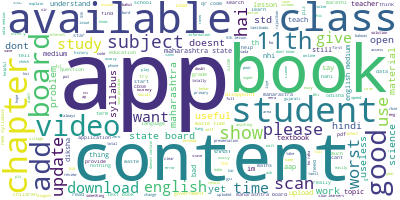

In [183]:
from wordcloud import WordCloud

#text = list(eng_df['Review Text'])
long_string = ','.join(c1_elem)
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

In [184]:
keyword_freq_per_cluster(c1_elem,3).to_dict()

{'class': 3,
 'app': 3,
 'bad app': 2,
 'need': 2,
 'board': 2,
 'content': 2,
 'problems': 2,
 'work': 2,
 'chapters': 2,
 'videos': 2,
 'appno useful content': 2,
 'download disgust application': 2,
 'std': 2,
 'maharashtra board': 2,
 'understand topic answer question': 1,
 'hi im manoj instal app': 1,
 'bakwasnot work': 1,
 'medium update software hindi medium students': 1,
 'app text book available': 1,
 'board maharashtra': 1,
 'tht problem': 1,
 'work phone mi note': 1,
 'doesnt teach': 1,
 'maharashtra state board content available': 1,
 'syllabus': 1,
 'pdf book primary basic education uttar pradesh': 1,
 'try open slabous app refuse dont': 1,
 'check': 1,
 'aap download waste time disappoint': 1,
 'th std useless app': 1}

In [185]:
import re
c1_most_frequent = [y for y in c1_elem if re.search('bad app', y)]


['useful students teachers also bad app ',
 'bad app work tomorrow maths exam bad app ',
 'bad app dont download plzzz poor quality cant open app cause app soo plz dont download student 10 th std useless app ',
 'bad app available chapter also say work ']

In [202]:
# m1_elem = elem_rate1['m']
# m1_elem

In [ ]:
# from wordcloud import WordCloud

# #text = list(eng_df['Review Text'])
# long_string = ','.join(m1_elem)
# wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# wordcloud.generate(long_string)
# wordcloud.to_image()

In [ ]:
# keyword_freq_per_cluster(m1_elem,4).to_dict()

In [ ]:
# import re
# m1_most_frequent = [y for y in m1_elem if re.search('content', y)]
# m1_most_frequent


# cluster element extraction for each rating


<ipython-input-115-b873e6abbf3f>:17: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 



{'g': ['worst app ever ',
  'totally worst app ever ',
  'worst app ever see ',
  'worst app forever ',
  'one worst app ',
  'worst app ever never use ',
  'worst app learn ',
  'wrost app ever ',
  'app worst app download byjus enjoy ',
  'worst app waste time download ',
  'worst app dont download net complete get answer donkey app ',
  'worst app result app give logo ',
  'fake worst application ',
  'fake app useful ',
  'one worst app ever usedplease dont instal app become cheat ',
  'worst chance block app lucky app ',
  'bad app game instal useful app pc game ',
  'worst work app mobile ',
  'work wrost app ',
  'work properly hang worst app ',
  'app always hang ',
  'really bad app never think ',
  'bad app world ',
  'good bad app ',
  'bad app use ',
  'bad app thirdclass ',
  'bad app work ',
  'vary bad app ',
  'bad app always work properly helpful emergency ',
  'app usfull content bad ',
  'bad experience worst app ever doesnt explain anything incomplete content ',
  'much behave like cheap app hate ',
  'app potentially harmful use camera background aware use ',
  'privacy data security danger ',
  'completely useless mebecausit open device please check download google user name eby ',
  'cant learn anything answer question dont download app ',
  'nt see videos question solve app helpful ',
  'dont usefull app ',
  'dont download app ',
  'bad app vorst app dont download worst app ',
  'app bad dont install ',
  'good app bore dont like app dont download app ',
  'worse app use app ',
  'dont download app good please dont download videos app also ',
  'please dont download hate app app videos app open long time take open ',
  'disappoint app guy plz dont install it ',
  'waste diksha app ',
  'waste app work ',
  'downloded app open waste app x ',
  'waste app dont download ',
  'one waste app never see please dont install app ',
  'waste app like app app take download half hour please dont download app ',
  'waste app install please ',
  'scan stick scan waste app ',
  'waste app able scan qr cod ',
  'worstthe qr cod work allit national waste ',
  'bad app click english display english need much improvement ',
  'usefull app english another ',
  'worst app submit language english maths show different language ',
  'app horrible useless appsorry say type word ',
  'useless app cant understand single word ',
  'app nothing want like 9 english lessons poems ',
  '3rd class app please dont download west time data also need develop please develop give play store ',
  'hello please make app available india great help ',
  'beautiful really like app great future everyone install app look well ok everybody come come come install app bright future thank everybody listen feedback send feedback wonderful game really like say say feedback f four star ask please beautiful game like game beautiful ',
  '3rd class app ekdam bekar useless everytime problem app suppose give even 1 star useless ',
  'really useless app content available class first eight ',
  'give app one star helpful work properly didnt get answer app diksha dont want tell worst app thank diksha ',
  'bad app give star app ',
  'use app u r ask rate app nonsense ',
  'nice app byjus nice app ',
  'nice app ameging ',
  'nice app p ',
  'nice use app student ',
  'avery nice app ',
  'good dlkdha app ',
  'app useful studentsoi like hope everyone feel good ',
  'diksha app good app solve many lekkas ',
  'useles app open bad waste time ',
  'bore app biju better ',
  'super app learn ',
  'good app learn much ',
  'app useful give knowledge things ',
  'yes app useful ',
  'like app verry usefull app ',
  'good app dont understand use it ',
  'diksha app bhangar app ',
  'sabse ghatiya app ',
  'diksha app downloding ',
  'faltu app hetime vasting ',
  'bakwas app open ',
  'app hlep well ',
  'app good stud actvites ',
  'like app get file check call record bring app hope would take remadi thank ',
  'app give information didnt get expect information ',
  

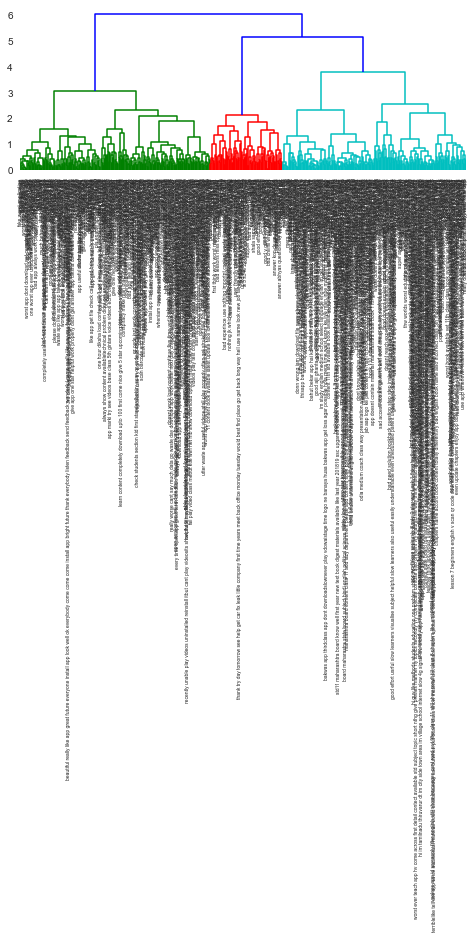

In [187]:
clustering_rating_wise(initial_df, 1)

<ipython-input-115-b873e6abbf3f>:17: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 



{'g': ['thing come app ',
  'app open try open ',
  'available data app ',
  'app usefull app super app ',
  'app open mobile ',
  'super mind app ',
  'app good accord education app function properly even phone also work properly diksha app work properly lag even network excellent ',
  'app great love diksha app great ',
  'app good love faster ',
  'app good std 11 update syallbuss come time study ',
  'app worst app ',
  'nothing seem useful inside content app worst design recommend everyone download app dont waste time data ',
  'good app subject yet add ',
  'awesome appi like app much ',
  'yes like app ',
  'good sometimes feel bore use app useful studentsa teacher much better use blackboardan unpractical app network problem also create issue class ',
  'useless app even play store 2 years ago 9th download app ad app give al textbooks help us understand concepts get app construction im 11th pcb student still app suck hope seniors get opportunity app ',
  'good learn app could help app contain content upto class 10 require class 12 content better provide class 12 content well ',
  'think app would help understand lessons understand class ask question lesson choose doesnt even video content ',
  'class 1112 material useless app ',
  'provide much feature work please resolve content also satisfactory better could provide class 11th 12th material ',
  'nothing show library need lot improvement ',
  'good learn app could help app contain content upto class 10 require class 12 content better provide class 12 content well ',
  'good app teachers students many feature app like language mediam others etc book available development short soo many qualities include app goood ',
  'good app education material available app make audiovisual avability ',
  'app well education ',
  'good app learn want learn easily app understand anything ',
  'learn app useful ',
  'supper learn app ',
  'develop app think app need lot useful interest attractive activities children ',
  'screaching 1 lesson set language exercise 13 3rd sum want reason plz use app use explain good execise plz put exercise alone learn others also learn easy put videos faster give one star give two star explain good ',
  'course best app ever make videos small diksha dont give information chapter please keep make videos long please give information indvidually point ',
  'dont like app l dont understand lessons app please improve app request ',
  'good app unable get information lessons social scan qr code sometimes show errors sometimes tellsinformation upload yetpls make lessons upload app ',
  'app good slow please improve ',
  'expsrience satisfactory need extra imprpvement also speed poor timetaking app want become best teach app soon best wish ',
  'app well education ',
  'show content available state kindly look mattr ',
  'please add content class ',
  'lead content problems ',
  'need lot improvement download video get stick start take lot time start againvery bad ',
  'useful ads r come kindly improve videos ',
  'like app first rat videos open message og please try content rat come video playingplease help thank reply none videos playingssc board10 gradeenglish mediumall subjectsmaharashtra write state though answer irritate guy ',
  'give ad short break ',
  'respect sir please help us use app offline condition cant online school hours face network problem villages user app due mention problem couldnt continue thank indeed sir reply ',
  'app doesnt access ios users management please allow access ios users may also compatible free use application ',
  'whenever try open say update profile fail please try later pls solve issue ',
  'say select boardwhen click open even respond please fix problem ',
  'hey everytime open application ask location please solve asap ',
  'cant use show email id invalid ',
  'performance app slow camparing educational app take least 5 minutes perform normally ',
  'good app work way slow wait like 20 minutes get ppt load lagapp '

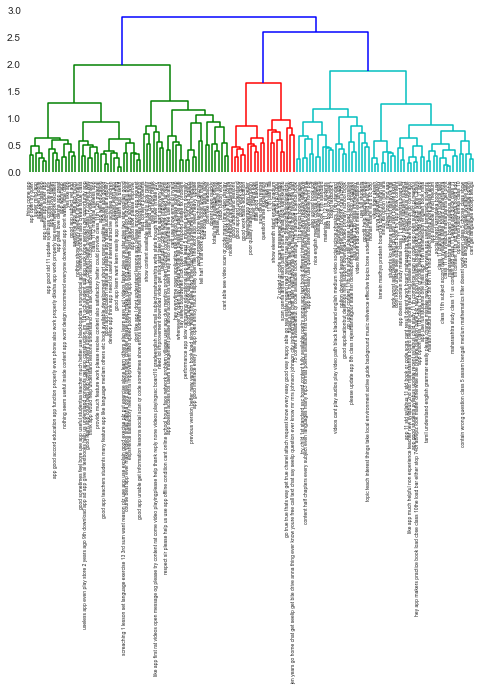

In [188]:
clustering_rating_wise(initial_df, 2)

<ipython-input-115-b873e6abbf3f>:17: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 



{'g': ['aap learner enjoyand learn interest ',
  'kuch lessons pending hain ',
  'diksha aap hindi medium students think ',
  'need update content per prescribe textbook english medium state board maharashtra 9th standard ',
  'subject book available odia medium ',
  'tell 11th syllabus content come maharashtra state bord ',
  'sir till 11 maharashtra board book add ',
  'two book class mybe good l hindi medium class 9th ',
  '8th class tak hindi medium walo ki book hi nhi haistate rajasthan medium hindi ',
  'add book punjabi medium ',
  'video standard sixth maharashtra board history civics subject lesson 9 ancient kingdoms south available kindly fix early possible thank ',
  '11th class videos come board maharashtra medium semi english u able subject ',
  'please best video quality indias best teacher insert diksha pleplepleplease ',
  'sanskrit lesson translate hindiand worksheet add question from burgess cgbsce 10th class ',
  'show question math 1and 2 class 10 maharashtra board ',
  'find marathi aksharbharti class 10th ',
  'want study materials physics chemistry biology mathematics english medium maharashtra state board education 11th class ',
  'go add maharashtra std 11th subject plz reply college start ',
  'increase rat quick response thank warm response want chapters maharashtra state board 11th standards physics chemistry mathematics biology marathi english subject thank ',
  '3 active response board medium hindi subject humara parivesh name content vashpan thank ',
  'cant download fetch content gujarat board std7 also cant find sign login screen app know gujarat board content available maths science fir std7 accessible app ',
  'cant download fetch content maharashtra state board 11th science class please kindly solve issue ',
  'good app nat able access ssc board marathi subject answer give cant open anything please something benefit ',
  'app okay contain hindi sparsh course b class 10 even almost time board hope chapters add soon ',
  'app doesnt offer practice question hindi course course b available pls check ',
  'important ques 26ths english cbse exam avalbl app ',
  'im private english medium school app one select medium hindi no ',
  '9th grade tamilnadu syllabus english subject none qr cod valid give content happen chemistry also subject ict corner qr cod work ',
  'science mathematics subject qr code work properly subject qr code doesnt work pls update app subject 9th class ',
  'plz add 1st year degree 3rd year degree plz ',
  'please update newly add english textbook ',
  'nice need content keep state book karnataka ',
  'isnt maharashtra english medium content add one subject please add content regard 11th standard expect ',
  'doesnt 11th maharashtra boardscience subjectsenglish medium content ',
  'bt maharastra state add contant 11 th std soo cant use app study plz add new content maharastra board ',
  'app good please add content 11th 12th standards cbse students especially ',
  'contain official cbse content ',
  'please add class 1st state board maharashtra ',
  'please add book 11th 12th std arent available maharastra state board ',
  'maharashtra state q r code accept app pls update ',
  'padhao india ko ',
  'jhhhhtubt word dai ko ',
  'kya soch ke banaya h kisi kam ka ni h ',
  'bahut achha hai lay ke saath ',
  'pls issme sabhi subject ke bare puri jankari jaldi se jaldi dale thank ',
  'problem hai ji ',
  '15 din se technical fault bta raha ',
  'use app teacherwe dont get content urdu medium std 1 app please provide content videos action content students learn easily maharashtra board urdu balbharti std 1 ',
  'iam kerala app good didnt get malayalam language lessons content please load content ',
  'good app hindi translate also compulsory ',
  'hindi content english ',
  'nice app ye good app jisse hame prkar ki suvida multi h nice supper supper good ',
  'mp mein bhi lagu karo na diksha app ',
  'nice app malayalam videos audio hear like eco give 3 star ',
  'please give videos h

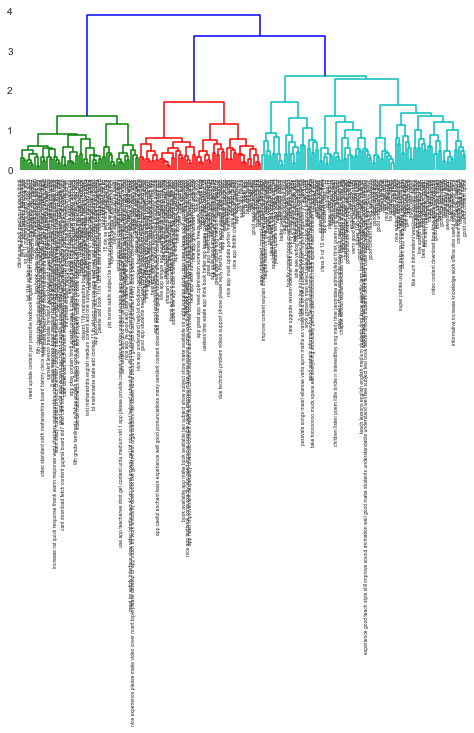

In [189]:
clustering_rating_wise(initial_df, 3)

<ipython-input-115-b873e6abbf3f>:17: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 



{'g': ['good learn app book qr scanner ',
  'great app download text book ',
  'good term book app want alterations provide us videos lessons chapters please see government authorities ',
  'good app learn chapter ',
  'app nice easy learn app learn chapters easily ',
  'super knowledgeable excellent app help quite study useful cct practice also give many question answer note chapters quite helpful ',
  'good learn think better byjus apps app everything like long answer videos chapters etccc ',
  'usefull brother chapter clear nice app ',
  'helpful useful app like meera say contain small chapters include important line pls make sure ',
  'really nice app me chapter divide many part part small please make better ',
  'good app sometime show small explanation doesnt let us understand whole chapter 50 percent chapter also want solution every question dont understand ',
  'good app enough video chapters ',
  'like app chapters available small ',
  'awesome app keep prepare board cant download pdf file question paper would 5 star still good app ',
  'well learn easy good app rat 4 star ',
  'get little bite knowledge app thank much diksha ',
  'exelent app improve knowledge ',
  'experience good learn app ',
  'best app learn less time ',
  'useful help app teach learn ',
  'useful teach someone useful app ',
  'help us learn easy good teach students vry awesome app easy read subject good learn app diksha ',
  'app usefull app make learn subject easier ',
  'lessons interest install app learn ',
  'easy learn good app ',
  'think good app one learn things use app ',
  'hey app good help better learn like app ',
  'like app learn ',
  'gud app give extra ques check knowledge ',
  'good useful app whereas problem occur try play practice book practice book arent open would kindly request look problem immediately would miss good chance prepare practice book thank you ',
  'app good children learn enjoy ing ',
  'helpful app hor child education ',
  'good love learn app best choices children learn ',
  'knowledgeable apps children ',
  'nice app eaisy learn app ',
  'nice app best lessons ',
  'awesome app learn teach ',
  'best learn app ever ',
  'good app learn teach ',
  'good app self learn teach ',
  'good teach app ',
  'really app useful understand also useful teach ',
  'good app learn easyly ',
  'nice apps kid nd teach method ',
  'good read learn app child teacher ',
  'nice educational app everyone ',
  'nice app educational qualification ',
  'nice app students lesson ',
  'nice app teachers nd students ',
  'nice app helpful teachrs nd students ',
  'good app good students ',
  'app good students ',
  'nice app education every students ',
  'reallly nice app students ',
  'app important school students much useful us every one therefore good ',
  'good app teachar student ',
  'good app rbse students ',
  'app good usefull students ',
  'good apps student learn ',
  'good app class 5th ',
  'good app need much learn videos class 10 science mathematics ',
  'good app learn need lessons social science tell topics teach full lesson person great way success ',
  'app good teacher student user phace good app give proper sulation every chapters ',
  'good app add 11th scc syllabus science ',
  'nice app complete study n teach ',
  'nice app really useful school studentsi appreciate diksha app effort easy understand topic students ',
  'good app also helpful also interest students ',
  'student use app ',
  'like app student need feature ',
  'student good app picture sound qualty dullsoplease solve problem ',
  'good application teachers students ',
  'good application teacher students ',
  'good app teachers students parent ',
  'good app teachers ',
  'teacher would say best app provide lot materials informations ',
  'reliable app teachers one thing would help would add one day lesson plan ',
  'students learn diksha app ',
  'useful ssc students must app ',
  'gowri student love app useful students suggest friends use app 

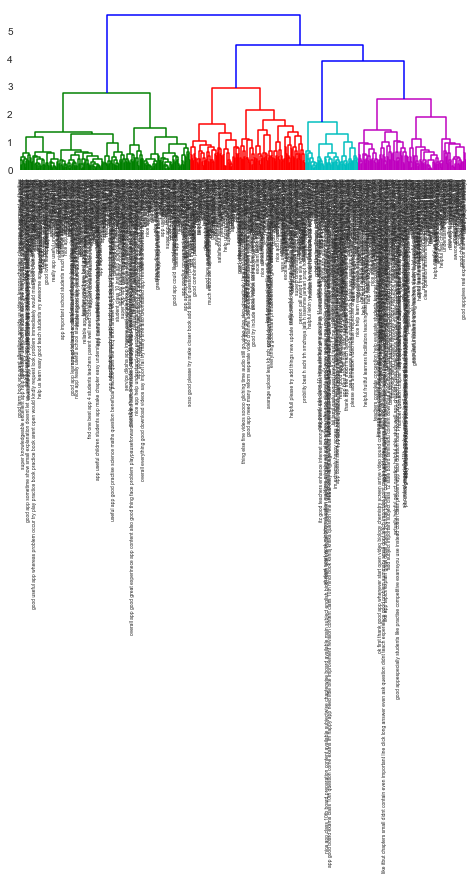

In [190]:
clustering_rating_wise(initial_df, 4)

<ipython-input-115-b873e6abbf3f>:17: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 



{'g': ['thank app help learn new things thank ',
  'app good learn things thank ',
  'thank diksha app learn quickly easly ',
  'like much understand lesson etc thank dikesha app create sir ',
  'helper app thank lot ',
  'many thank app helpful ',
  'helpfull app thank ',
  'thank much much app ',
  'fabulous app learnerstruly helpful really appreciate ',
  'osam app love thank much ',
  'good app thank ',
  'app nice thank ',
  'thank thank much good app ',
  'great app thank much ',
  'useful app thank u ',
  'wow nice thank app ',
  'good app thanku much ',
  'nice helpful want improvements app thank ',
  'nice app really helpful good creativity content much appreciate ',
  'good app thank u make woundreful app take much time lod also like app ',
  'thank app make ',
  'thank make app ',
  'thank provide app ',
  'thank give app ',
  'thank sir make app ',
  'thank make like apps ',
  'thank app useful life ',
  'thank u help worlds best app ',
  'thank app amaze app appreciate ',
  'thank u app ',
  'thank thus app ',
  'thank diksha app ',
  'thank app diksha ',
  'thank diksha app one 1 app ',
  'thank app 8std history complete ',
  'excellent app congratulation thanx team diksha ',
  'app thank diksha team ',
  'thish app use full app thaks allat ',
  'nice app sugguest prople try app thank diksha ',
  'diksha read app nice ok thank sir ',
  'awesome app thank diksha ',
  'nice thank diksha app thank number one diksha app nice good ',
  'thank diksha diksha great app ',
  'nice app thank aoo ',
  'excellent app service happy ',
  'good experience also good app ',
  'super great app ',
  'super fantastic app ',
  'amaze awesome app ',
  'superb app really like ',
  'super cool app ',
  'good app really enjoy ',
  'really good app ',
  'verry good app ',
  'app really good ',
  'great full app ',
  'super app good ',
  'yes app fantastic ',
  'app nice good ',
  'app nice wonderful ',
  'good app awesome ',
  'good app superb ',
  'excellent good app ',
  'good app nice app ',
  'nice best app ',
  'nice simply vrey good app ',
  'good app excellent work ',
  'awesome app good work ',
  'nice app love it ',
  'nice app love ',
  'nice app beautiful ',
  'super nice app ',
  'realy nice app ',
  'good app nice ',
  'good nice app ',
  'nice excellent app ',
  'wow nice app ',
  'nice useful app well come ',
  'thats good app ',
  'thats useful app ',
  'good app like much ',
  'good app explaning clearly ',
  'nice app easy use ',
  'nice app easy ',
  'excellent app easy use ',
  'nice app useful also ',
  'nice app quite useful ',
  'nice app useful ',
  'nice app usefull ',
  'wow nice useful app ',
  'good nice useful app ',
  'nice useful app 1010 ',
  'nice helpful app ',
  'nice app helpful app ',
  'nice helpfull app ',
  'helpful app excellent ',
  'nice informative app ',
  'nice app helpful educatiar ',
  'nice app like ',
  'awesome app like ',
  'nice app read ',
  'nice app information ',
  'awesome app buffer ',
  'much nice app ',
  'much helpful app ',
  'much good kid l like app ',
  'much super creative ',
  'nice app next daylewis ',
  'nice app lear ',
  'nice app usful ',
  'nice app childrenhttps ',
  'nice app childres ',
  'nice application app learing ',
  'nice app king ',
  'nice app stundents wonderfull creation ',
  'nice work app ',
  'good work app ',
  'nice tha app ',
  'nice app bro ',
  'veey nice app ',
  'kadk app nice app ',
  'thses nice app ',
  'vvv nice app ',
  'love thes app ',
  'nice diksha app ',
  'diksha app nice ',
  'nice disharmony app ',
  'nice red app ',
  'nice effictive app stud home ',
  'happy use app ',
  'happy super app ',
  'happy diksha app ',
  'good app love ',
  'awesome app love ',
  'mm good app love ',
  'nice app love app ',
  'love app much ',
  'wow wonder ful app love ',
  'app cool nice hav congregation app ',
  'learn app much ',
  'app learn much ',
  'app nice like app much learn subject much ',
  'like app learn easy ',
  'like app useful lear

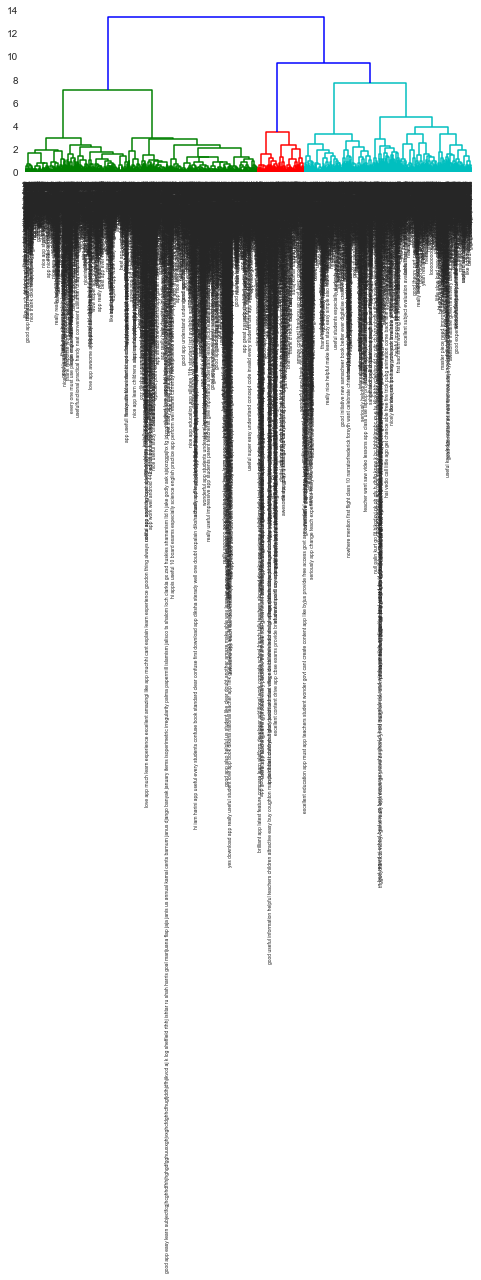

In [191]:
clustering_rating_wise(initial_df, 5)


# LDA - Topic Modelling for each rating


In [192]:
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

In [193]:
def stemSentence(sentence):
    token_words=word_tokenize(sentence)
    defaultPos = nltk.pos_tag(token_words) # get the POS tags from NLTK default tagger
    words_lemma = []
    
    #mapping to wordnet lemmatazer
    pos_to_wn = {"JJ": 'a',
             "JJR": 'a',
             "JJS": 'a',
             "NN": 'n', 
             "NNS": 'n', 
             "NNP": 'n', 
             "NNPS": 'n', 
             "VB": 'v',
             "VBD": 'v',
             "VBG": 'v',
             "VBN": 'v',
             "VBP": 'v',
             "VBZ": 'v',
             "RB": 'r',
            "RBR": 'r',
            "RBS": 'r'}
    for item in defaultPos:
        try:
            words_lemma.append(wordnet_lemmatizer.lemmatize(item[0],pos_to_wn[item[1]]))
        except:
            words_lemma.append(item[0])
        #words_lemma.append(lemmatizer.lemmatize(item[0],pos_to_wn(item[1])))
    return " ".join(words_lemma)
#stemSentence(text[0])

In [194]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()


In [195]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [196]:
def LDA_Topic_Modeling_Plotting(text):
    count_vectorizer = CountVectorizer(stop_words='english', ngram_range=(1, 3))
    count_data = count_vectorizer.fit_transform(text)
    plot_10_most_common_words(count_data, count_vectorizer)

    # Tweak the two parameters below
    number_topics = 4
    number_words = 8

    # Create and fit the LDA model
    lda = LDA(n_components=number_topics, n_jobs=-1)
    lda.fit(count_data)

    print("Topics found via LDA:")
    print_topics(lda, count_vectorizer, number_words)

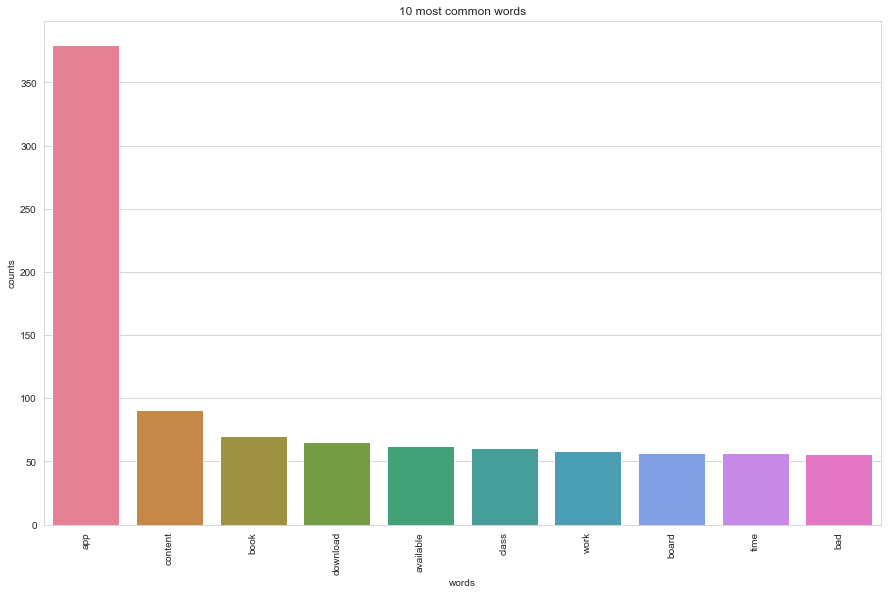

Topics found via LDA:

Topic #0:
app content board available video english medium 11th

Topic #1:
app content good scan work say qr code

Topic #2:
app video play board content use subject work

Topic #3:
app book download class bad dont time content


In [197]:
rating1_text = list(initial_df[initial_df['Star Rating']==1]['Review Text'])
LDA_Topic_Modeling_Plotting(rating1_text)

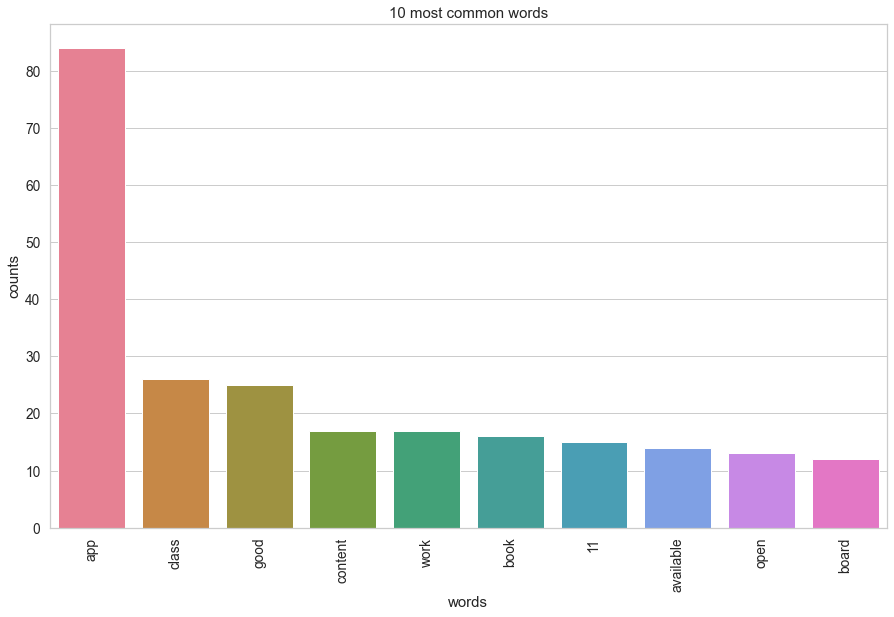

Topics found via LDA:

Topic #0:
app class work available syllabus 11 content good

Topic #1:
app good book class videos video load new

Topic #2:
app open dont try update book class understand

Topic #3:
app good content class work true learn book


In [198]:
rating2_text = list(initial_df[initial_df['Star Rating']==2]['Review Text'])
LDA_Topic_Modeling_Plotting(rating2_text)

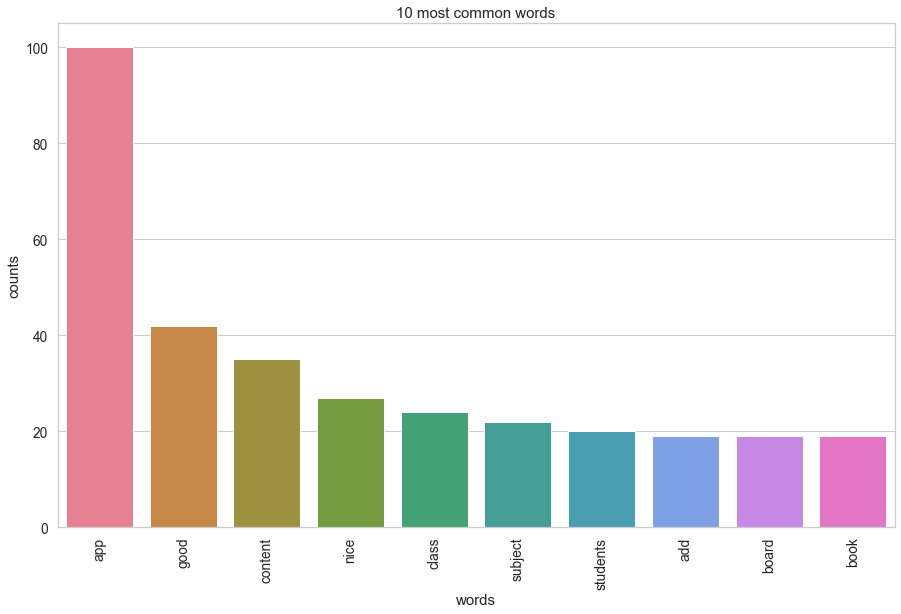

Topics found via LDA:

Topic #0:
app good thank nice board book subject content

Topic #1:
app content class good students medium board hindi

Topic #2:
app content nice learn add like work available

Topic #3:
app good nice subject learn make nice app improve


In [199]:
rating3_text = list(initial_df[initial_df['Star Rating']==3]['Review Text'])
LDA_Topic_Modeling_Plotting(rating3_text)

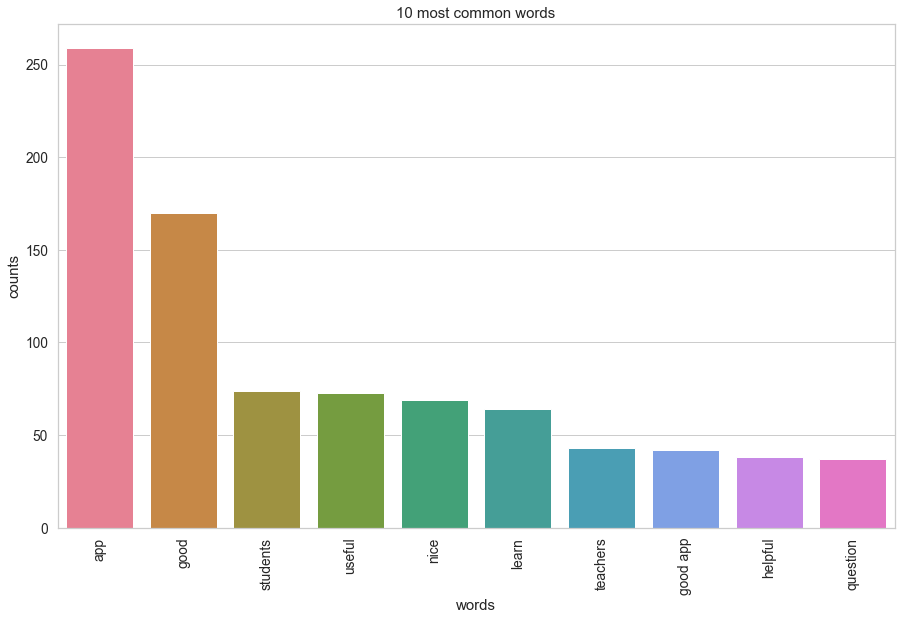

Topics found via LDA:

Topic #0:
app good students useful helpful question teachers content

Topic #1:
app good students learn useful nice teachers use

Topic #2:
app good learn teach videos useful best super

Topic #3:
app good nice students nice app useful good app education


In [200]:
rating4_text = list(initial_df[initial_df['Star Rating']==4]['Review Text'])
LDA_Topic_Modeling_Plotting(rating4_text)

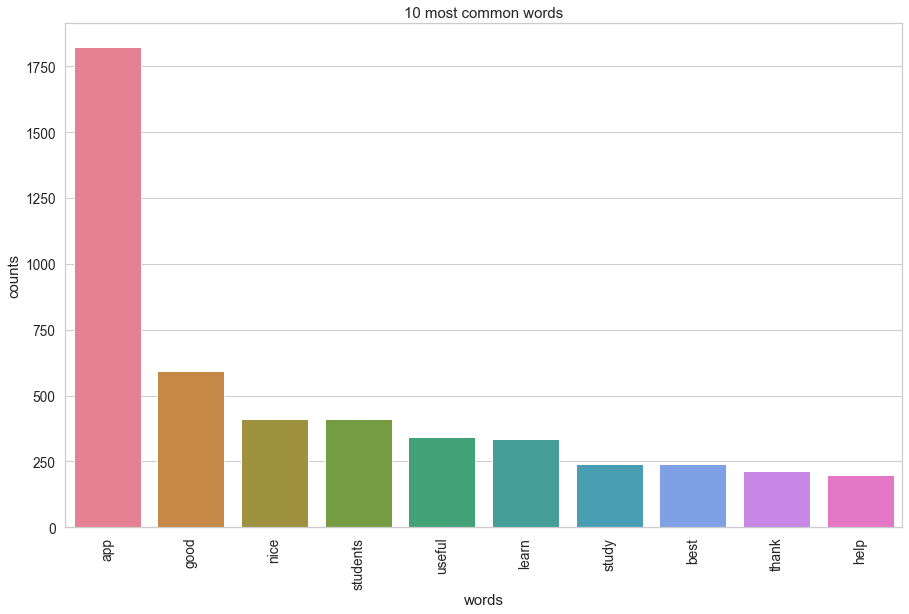

Topics found via LDA:

Topic #0:
app good learn diksha nice useful thank study

Topic #1:
app nice good students useful use helpful best

Topic #2:
app students good learn useful teachers help super

Topic #3:
app good nice study useful students nice app really


In [201]:
rating5_text = list(initial_df[initial_df['Star Rating']==5]['Review Text'])
LDA_Topic_Modeling_Plotting(rating5_text)

In [ ]:
def clustering_rating_upto_3(key_rate_df):
    key_data = key_rate_df.loc[key_rate_df['Star Rating'] <= 3]
    key_rate_df1 = pd.DataFrame(key_data)
#     return key_rate_df1
    ky_ls =key_rate_df1['Review Text'].tolist()
    
    frame = vectorization_of_list(ky_ls)
    frame.set_index(key_rate_df1["Review Text"], inplace = True) 
    return cluster_element_extraction(frame)

<ipython-input-115-b873e6abbf3f>:17: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 



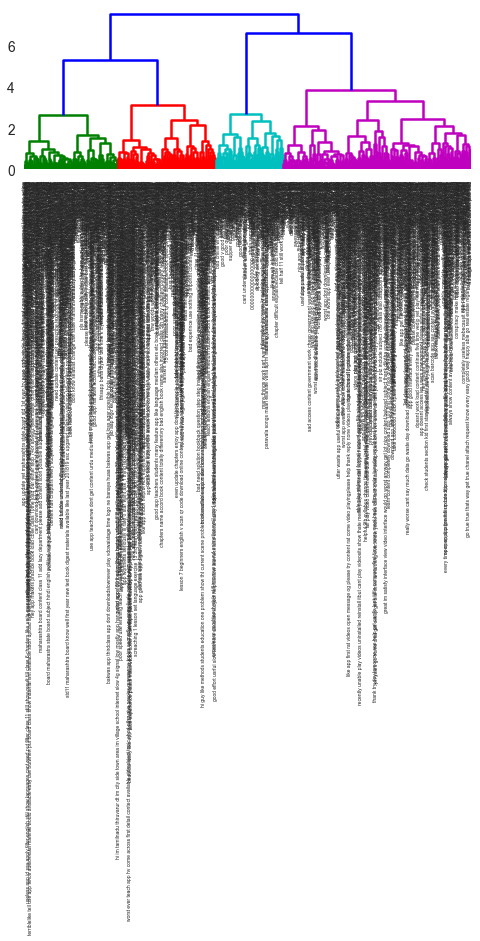

In [205]:
cluster_upto_rate3 = clustering_rating_upto_3(initial_df)

In [206]:
cluster_upto_rate3

{'g': ['app update yet maharashtra state board std 1st even try scan code single lesson doesnt open hope someone review comment take require action ',
  'maharashtra state q r code accept app pls update ',
  'book 110 odia medium add state district name update error msg show odisha ganjam dist ',
  'please add book 11th 12th std arent available maharastra state board ',
  'get maharashtra board 11 std book apk ',
  'show maharashtra state 11 th std book information available ',
  'get anything able scan textbook qr code say content add yet gon na add std 11 state maharashtra ',
  'app 11 std syllabus 11 std book qr code scan cant result doesnt work board maharashtra plz upload syllabus request ',
  'get maharashtra board 11 std book apk ',
  'really useless app play rbse videos doesnt start play cbse video start useless secondly rbse matter available hindi despite select english medium really ridiculous app 1 star cant leave blank ',
  'useless app id say apply filter english still show languages cant read put filter class 11 still show result till class 6 chapters like units measurements include videos doesnt videos subject like electronics english new syllabus hssc board maharashtra yet update doesnt even show result older syllabus app even good things reflect ',
  'worst app board ssc app show board put board maharashtra search many time chapter want even scan qr code lesson also place book say download app still come delete whoever download dont ',
  'terriblelike tell use app since audiovisual material would available easy use butwhen put board class show material isnt available soon upload like seriously upload book study material beforehand totally terrible appi extremely extremely dissatisfy disappoint app want maharashtra board11th standard english mediumbut wasnt availablesorry ',
  'teacher think app would useful pain neck show owner video grant access sign explain way already uninstalled useless app maharashtra state board 3rd 5th standar subject english maths ',
  'app doesnt contain maharashtra state board book bad ',
  'app doesnt contain material maharashtra state book 11th grade make profile show state maharashtra misguide ',
  'app doesnt contain study material class 11 maharashtra board till ',
  'app doesnt material 11thsci exams nearer government maharashtra add content app ',
  'maharashtra 11th syllabus yet give app worst app everrr dont download ittt ',
  'till bihar board book content didnt update hate slow update ',
  'hey app makers practice book load cbse class 10the load bar either stop 74or at99plz look matter otherwise able prepare question bank plz reply soon possible board exams approach within 3days ',
  'content cbse english able scan 4 th class maths ',
  'go cbse page error book pls add cbse book faster ',
  'andhrapradesh state syllabus telugu medium textbooks error cotent load ',
  'official cbse nothings work ',
  'cant download fetch content gujarat board std7 also cant find sign login screen app know gujarat board content available maths science fir std7 accessible app ',
  'cant download fetch content maharashtra state board 11th science class please kindly solve issue ',
  'cant open content 11 science maharashtra board book english medium matter ',
  'app doesnt full content class 6 7 odia medium please check solve problem please provide concepts ',
  'tamil class 1 content load pls help ',
  'odia medium coach class way presentation worse please remove background music prvide high quality pdf get things clear please please please ',
  'cant find state board west bengal ',
  'please add class 1st state board maharashtra ',
  'maharashtra study class 11 us content add class 11 please add quick class 11 ',
  'maharashtra board content class 11 add lazy department please add content soon possible students future nationso eager teach student except thing delay portion humble request add content soon possible thank ',
  'app good please add content 11th 12th standards cbse students espec

In [208]:
def clustering_rating_greater_than_3(key_rate_df):
    key_data = key_rate_df.loc[key_rate_df['Star Rating'] > 3]
    key_rate_df1 = pd.DataFrame(key_data)
#     return key_rate_df1
    ky_ls =key_rate_df1['Review Text'].tolist()
    
    frame = vectorization_of_list(ky_ls)
    frame.set_index(key_rate_df1["Review Text"], inplace = True) 
    return cluster_element_extraction(frame)

<ipython-input-115-b873e6abbf3f>:17: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 



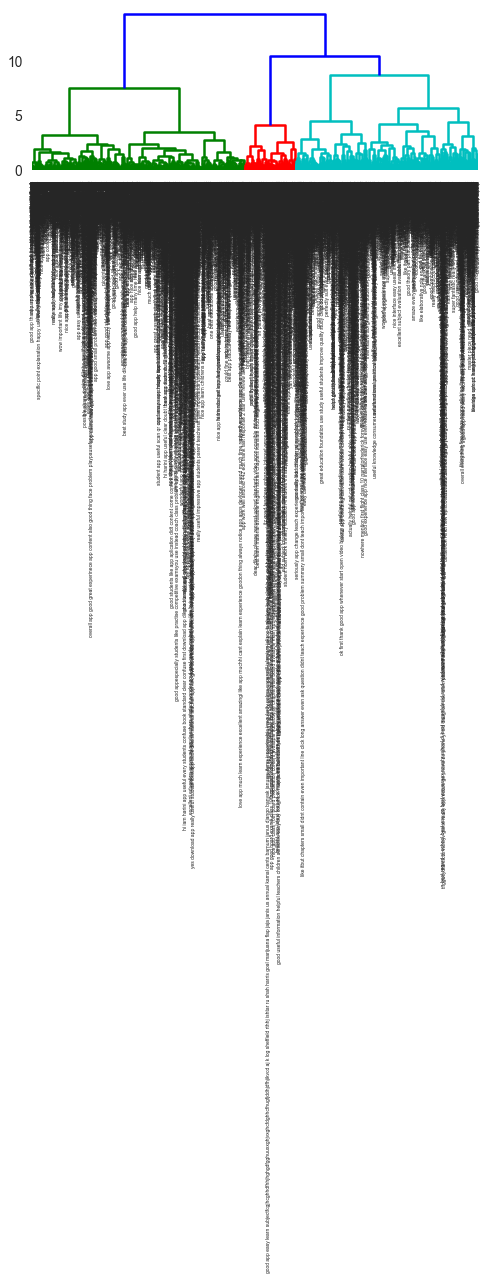

In [209]:
cluster_greater_than_rate3 = clustering_rating_greater_than_3(initial_df)

In [210]:
cluster_greater_than_rate3

{'g': ['thank app help learn new things thank ',
  'app good learn things thank ',
  'app appropriate cause app provide lot knowledge thankyou ',
  'good app thank u make woundreful app take much time lod also like app ',
  'super app thank iam like app ',
  'helper app thank lot ',
  'nice helpful want improvements app thank ',
  'many thank app helpful ',
  'helpfull app thank ',
  'thank much much app ',
  'fabulous app learnerstruly helpful really appreciate ',
  'osam app love thank much ',
  'good app thank ',
  'app nice thank ',
  'thank thank much good app ',
  'great app thank much ',
  'useful app thank u ',
  'wow nice thank app ',
  'good app thanku much ',
  'thank app make ',
  'thank make app ',
  'thank provide app ',
  'thank give app ',
  'thank sir make app ',
  'thank make like apps ',
  'thank app useful life ',
  'thank u help worlds best app ',
  'thank app amaze app appreciate ',
  'thank u app ',
  'thank thus app ',
  'thank diksha app ',
  'thank app diksha ',
  'thank diksha app one 1 app ',
  'thank app 8std history complete ',
  'im lot information app thank diksha ',
  'excellent app congratulation thanx team diksha ',
  'app thank diksha team ',
  'thish app use full app thaks allat ',
  'nice app sugguest prople try app thank diksha ',
  'diksha read app nice ok thank sir ',
  'awesome app thank diksha ',
  'nice thank diksha app thank number one diksha app nice good ',
  'thank diksha diksha great app ',
  'nice app thank aoo ',
  'great help app explanation good easy understand ',
  'nice app explanations easy understand ',
  'super app good explanation ',
  'nice app goods knowledge ',
  'nice give app 5 star explanation good improve facilities ',
  'thank diksha app learn quickly easly ',
  'like much understand lesson etc thank dikesha app create sir ',
  'specific point explanation happy use every day classmakes teach learn comfortable thank this app ',
  'excellent app helpful understand concepts 5 minutes ',
  'nice app really helpful understand portion ',
  'nice app lot know easily understand subject ',
  'nice app understand everything ',
  'really nice app improve knowledge ',
  'really excellent app useful grab extra knowledge ',
  'nice app get lot knowledge practicallythank ',
  'also useful app like samagra easy understand quickly ',
  'good learn app ',
  'good learn app like ',
  'good app learn ',
  'good app l learn ',
  'good app e learn ',
  'nice app good learn ',
  'good app good learn ',
  'great app learn ',
  'excellent app learn ',
  'superb app learn ',
  'excellent app teach learn ',
  'nice app learn ',
  'app nice learn ',
  'app good learn ',
  'app beautiful learn ',
  'good learn app son ',
  'nice app learn consepts clear ',
  'nice app e learn ',
  'nice app understand lessons well ',
  'nice great app learn subject ',
  'nice app best lessons ',
  'nice learn app ',
  'nice app eaisy learn app ',
  'nice easy learn app ',
  'nice app make easy learn ',
  'nice app easy learn ',
  'nice learn app easy ',
  'really nice app easy learn lessons ',
  'nice app easy learn concepts score mark ',
  'happy use app ',
  'happy super app ',
  'good app love ',
  'awesome app love ',
  'mm good app love ',
  'nice app love app ',
  'love app much ',
  'wow wonder ful app love ',
  'good hear app ',
  'goid app agree ',
  'nice app next daylewis ',
  'nice app lear ',
  'nice tha app ',
  'nice app bro ',
  'nice work app ',
  'good work app ',
  'nice app king ',
  'excellent app inprove ',
  'nice app helpful educatiar ',
  'nice app usful ',
  'nice app childrenhttps ',
  'nice app childres ',
  'nice application app learing ',
  'veey nice app ',
  'kadk app nice app ',
  'thses nice app ',
  'vvv nice app ',
  'love thes app ',
  'nice effictive app stud home ',
  'nice app kv ',
  'nice app useful tr st ',
  'nice lean app ',
  'nice h app ',
  'nice diksha app ',
  'diksha app nice ',
  'nice disharmony app ',
  'nice red app ',
  'app cool nice hav congregation